## Import Libraries and Input Key Functions

In [1]:
# Jupyer Notebook Theme: jt -t monokai -f fira -fs 10 -nf ptsans -nfs 11 -N -kl -cursw 2 -cursc r -cellw 95% -T
# Check python version
import sys
cdPyVer = 0x600
cdSysVer = sys.version[:5]
print("%s%s" %("My python version is: ", cdSysVer)) # strangely it works only on 3.7.4 and not 3.7.6

# Import libraries
import pandas as pd 
import numpy as np
import warnings

# Progress Bar
from tqdm.auto import tqdm

# Visualisation Libraries
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib.gridspec import GridSpec
plt.style.use('seaborn-dark') # use this theme as you are using dark theme in the notebook
import seaborn as sns
import folium
from folium.plugins import HeatMap, FastMarkerCluster

# Utility Modules
sys.path.append('/Users/Shandeep/qc_data_insights/personal/shandeep/scripts/')
from viz_utils import *

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
              
warnings.filterwarnings('ignore')

My python version is: 3.9.7


#### BQ Table/Schema Functions

In [2]:
def bq_table_info(bqclient, project, dataset, table):
    "print table details from BQ API"
    t = bqclient.get_table(f'{project}.{dataset}.{table}')

    print( 'Type:          ', t.table_type)
    print(f'Row count:      {t.num_rows:,}')
    print( 'Column count:  ', len(t.schema))
    print( 'Size:          ', u.convert_bytes(t.num_bytes))
    print( 'Table created: ', str(t.created)[:19])
    print( 'Last modified: ', str(t.modified)[:19])
    print( 'Description:   ', t.description)
    print( 'Labels:        ', t.labels)
    print( 'Partitioned by:', t.partitioning_type)
    print( 'GCP location:  ', t.location)
    
def bq_schema_df(bqclient, project, dataset, table) -> pd.DataFrame:
    "return dataframe with schema details"
    table_obj = bqclient.get_table(f'{project}.{dataset}.{table}')
    schema = table_obj.schema
    
    df = pd.DataFrame(index=range(len(schema)),
                      data = {'name': [col.name       for col in schema],
                              'type': [col.field_type for col in schema],
                              'mode': [col.mode       for col in schema],
                              'description': [col.description for col in schema]
                             })
    
    return df
  


## Connection to BigQuery

In [3]:
"""
Connect to big query and then run analysis acordingly.
"""

import sys
sys.path.append('/Users/Shandeep/qc_data_insights/utils/') # git clone this repository qc_data_insights
import utils as u 

import os
from google.oauth2 import service_account
# pip install google-cloud-bigquery==1.24.0 # requires this version.. current version is bugged with pandas
from google.cloud import bigquery

google_credentials_path = os.path.expanduser('~')+'/Documents/google_cloud_data-insights-team.json' # make sure add json file credentials in documents folder
credentials = service_account.Credentials.from_service_account_file(google_credentials_path)
bqclient = bigquery.Client(credentials=credentials, project=credentials.project_id)
print(f'Connected to BigQuery, project: {bqclient.project} on version {bigquery.__version__}')
print(f'Service Account Email: {bqclient.get_service_account_email()}')

Connected to BigQuery, project: dh-darkstores-live on version 1.24.0
Service Account Email: bq-1010543247368@bigquery-encryption.iam.gserviceaccount.com


## Table Information

In [4]:
project = 'dh-darkstores-live'
dataset = 'cl_data_science_qcommerce'
table   = '_promo_roi_out_roi_tableau_report'

t = bqclient.get_table(f'{project}.{dataset}.{table}')
print(f'Table: {project}.{dataset}.{table}')
print("____________________________________________________________________")
print("")
print(bq_table_info(bqclient, project, dataset, table))

Table: dh-darkstores-live.cl_data_science_qcommerce._promo_roi_out_roi_tableau_report
____________________________________________________________________

Type:           TABLE
Row count:      3,586,399
Column count:   38
Size:           1.40 GB
Table created:  2021-12-01 23:26:36
Last modified:  2021-12-01 23:26:36
Description:    Promo ROI Model Tableau Report
Labels:         {}
Partitioned by: DAY
GCP location:   US
None


#### Schema

In [5]:
schema_df = bq_schema_df(bqclient, project, dataset, table)
print(schema_df.groupby('type')['name'].count()) 
schema_df

type
BOOLEAN       1
DATE          2
FLOAT        17
INTEGER       1
STRING       14
TIMESTAMP     3
Name: name, dtype: int64


,name,type,mode,description
0,order_date,DATE,NULLABLE,None
1,global_entity_id,STRING,NULLABLE,None
2,warehouse,STRING,NULLABLE,None
3,supplier,STRING,NULLABLE,None
4,sku,STRING,NULLABLE,None
5,no_of_campaigns,INTEGER,NULLABLE,None
6,campaign_id,STRING,NULLABLE,None
7,campaign_name,STRING,NULLABLE,None
8,campaign_created_time_utc,TIMESTAMP,NULLABLE,None
9,campaign_start_time_utc,TIMESTAMP,NULLABLE,None


#### Column types

In [6]:
cols_numeric  = schema_df.loc[schema_df['type'].isin(['FLOAT', 'INTEGER', 'NUMERIC']),   'name'].values
cols_datetime = schema_df.loc[schema_df['type'].isin(['DATE', 'DATETIME', 'TIMESTAMP']), 'name'].values
cols_boolean  = schema_df.loc[schema_df['type'].isin(['BOOLEAN']),                       'name'].values
cols_object   = schema_df.loc[schema_df['type'].isin(['STRING', ]),                      'name'].values

In [7]:
# Some types are not supported by pandas
cols_not_supported = schema_df.loc[schema_df['type']=='RECORD', 'name'].values
cols_not_supported

array([], dtype=object)

#### Query

In [8]:
# WHERE RAND() < 10000/{t.num_rows} --- Add this if you are looking for 100000 random rows
query =f""" 
SELECT *
FROM `{project}.{dataset}.{table}`
WHERE RAND() < 10000/{t.num_rows}
"""
# Read query and display in the form of a pandas dataframe
df = u.read_bigquery(query, bqclient, parse_dates=[], verbose=True)
df.head()

running query... job done, downloading... 

Downloading:   0%|          | 0/10167 [00:00<?, ?rows/s]

done with shape (10167, 38)


,order_date,global_entity_id,warehouse,supplier,sku,no_of_campaigns,campaign_id,campaign_name,campaign_created_time_utc,campaign_start_time_utc,campaign_end_time_utc,is_campaign_active,category,subcategory,brand,product,y_pred_base,y_pred,b_qty,qty_sold,incremental_quantity_tab,is_outlier_incremental_quantity,price_base,price,cost,b_gmv,gmv,incremental_gmv_tab,is_outlier_incremental_gmv,b_profit,profit,profit_ext,incremental_profit_ext_tab,is_outlier_incremental_profit_ext,execution_date,confidence,discount,externally_funded_percentage
0,2020-07-09,FP_TH,Lat Phrao,Thainamthip Commercial Limited,99G241,1,819cc44c-e9ae-4af7-92c5-fc2b81a19f6f,BV 1-15 Jul 7%,2020-06-30 13:38:45+00:00,2020-06-30 17:00:00+00:00,2020-07-15 14:00:00+00:00,True,Beverages,Soft Drinks,Sprite,Sprite Soft Drink Original 1.5L Single,2.92,3.46,7.59,9.0,18.577075,No,27.00,25.11,23.97,205.03,225.99,10.222894,No,23.01,10.26,10.26,-55.410691,No,2021-12-01,very high,7.0,0.0
1,2020-07-10,FP_SG,Yishun,Toll Distribution Center,7K86VS,3,79239516-4525-4e0f-bd5a-91ad25dd7069,w28_new,2020-07-05 08:34:07+00:00,2020-07-05 16:00:00+00:00,2020-07-12 16:00:00+00:00,True,"Wine, Beer, Spirits",Beer (Single),Chang,Chang Beer Can | 500 ml,5.06,9.36,2.16,4.0,85.185185,No,4.30,3.50,3.25,9.29,14.00,50.699677,No,2.27,1.00,4.20,85.022026,No,2021-12-01,medium,19.0,100.0
2,2020-05-11,FP_SG,Woodlands 11,Toll Distribution Center,NON831,3,78910e30-1e74-4a40-9d01-364990161c43,w20_8th_bday,2020-05-08 10:06:43+00:00,2020-05-10 17:00:00+00:00,2020-05-24 17:00:00+00:00,True,Beverages,Iced Tea,Heaven and Earth,Heaven & Earth Mango Green Tea Bottle 1.5L,15.48,23.71,30.04,46.0,53.129161,No,2.05,1.72,1.78,61.58,79.12,28.483274,No,8.11,-2.76,12.42,53.144266,No,2021-12-01,very high,16.0,100.0
3,2020-05-11,FP_SG,Gemini@Sims,Toll Distribution Center,CW0GNG,3,78910e30-1e74-4a40-9d01-364990161c43,w20_8th_bday,2020-05-08 10:06:43+00:00,2020-05-10 17:00:00+00:00,2020-05-24 17:00:00+00:00,True,Beverages,Iced Tea,Heaven and Earth,Heaven & Earth Ice Passion Fruit Tea Bottle | 1.5 L,2.41,3.58,4.04,6.0,48.514851,No,2.05,1.75,1.78,8.27,10.50,26.964933,No,1.09,-0.18,1.62,48.623853,No,2021-12-01,very high,15.0,100.0
4,2020-03-04,FP_SG,Yishun,Toll Distribution Center,3GYX18,1,71163ab3-5733-440e-84e0-2a42769ef3b2,SongHe Thai Hom Mali Rice 1Kg,2020-02-27 02:59:11+00:00,2020-03-01 17:00:00+00:00,2020-03-29 15:00:00+00:00,True,Staples,Fragrant Rice,Songhe,SongHe Thai Hom Mali Rice 1KG,2.14,3.17,2.03,3.0,47.783251,No,4.20,3.80,3.14,8.51,11.40,33.960047,No,2.15,1.98,3.18,47.906977,No,2021-12-01,very high,10.0,100.0


#### Country Representation in Dataset

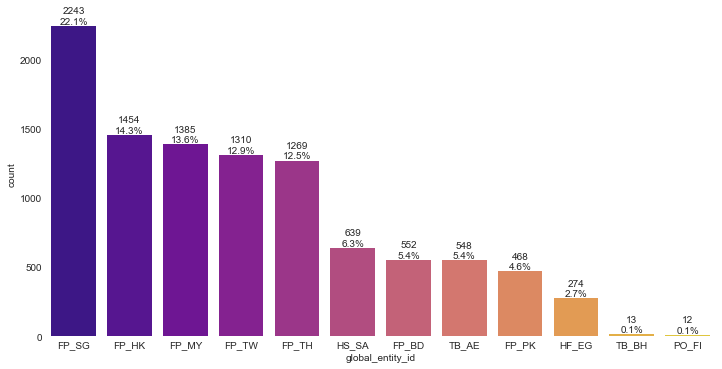

In [137]:
fig, ax = plt.subplots(figsize=(12, 6))
single_countplot(df, x='global_entity_id', ax=ax)
plt.show()

#### Datapoints by Order Date

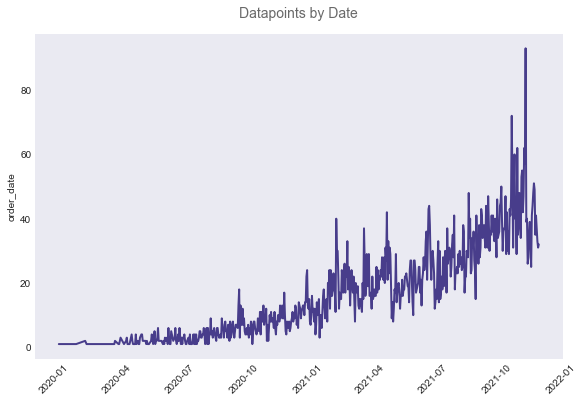

In [143]:


fig = plt.figure(constrained_layout=True, figsize=(8, 10))

# Axis definition
gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, :])


# Lineplot - Evolution of e-commerce orders along time 
sns.lineplot(data=df['order_date'].value_counts().sort_index(), ax=ax1, 
             color='darkslateblue', linewidth=2)

for tick in ax1.get_xticklabels():
    tick.set_rotation(45)
ax1.set_title('Datapoints by Date', y = 1.03, size=14, color='dimgrey');



In [9]:
df[df.duplicated()].head()# don't know why it's not working as expected

,order_date,global_entity_id,warehouse,supplier,sku,no_of_campaigns,campaign_id,campaign_name,campaign_created_time_utc,campaign_start_time_utc,campaign_end_time_utc,is_campaign_active,category,subcategory,brand,product,y_pred_base,y_pred,b_qty,qty_sold,incremental_quantity_tab,is_outlier_incremental_quantity,price_base,price,cost,b_gmv,gmv,incremental_gmv_tab,is_outlier_incremental_gmv,b_profit,profit,profit_ext,incremental_profit_ext_tab,is_outlier_incremental_profit_ext,execution_date,confidence,discount,externally_funded_percentage


#### Data types

In [10]:
df.dtypes

order_date                                        object
global_entity_id                                  object
warehouse                                         object
supplier                                          object
sku                                               object
no_of_campaigns                                    int64
campaign_id                                       object
campaign_name                                     object
campaign_created_time_utc            datetime64[ns, UTC]
campaign_start_time_utc              datetime64[ns, UTC]
campaign_end_time_utc                datetime64[ns, UTC]
is_campaign_active                                  bool
category                                          object
subcategory                                       object
brand                                             object
product                                           object
y_pred_base                                      float64
y_pred                         

In [11]:
cols_numeric

array(['no_of_campaigns', 'y_pred_base', 'y_pred', 'b_qty', 'qty_sold',
       'incremental_quantity_tab', 'price_base', 'price', 'cost', 'b_gmv',
       'gmv', 'incremental_gmv_tab', 'b_profit', 'profit', 'profit_ext',
       'incremental_profit_ext_tab', 'discount',
       'externally_funded_percentage'], dtype=object)

In [12]:
cols_object

array(['global_entity_id', 'warehouse', 'supplier', 'sku', 'campaign_id',
       'campaign_name', 'category', 'subcategory', 'brand', 'product',
       'is_outlier_incremental_quantity', 'is_outlier_incremental_gmv',
       'is_outlier_incremental_profit_ext', 'confidence'], dtype=object)

In [13]:
for col in cols_numeric:
    df[col] = pd.to_numeric(df[col], errors='raise')

cols_numeric_2 = ['no_of_campaigns', 'y_pred_base', 'y_pred', 'b_qty', 'qty_sold',
       'incremental_quantity_tab', 'price_base', 'price', 'cost', 'b_gmv',
       'gmv', 'incremental_gmv_tab', 'b_profit', 'profit', 'profit_ext',
       'incremental_profit_ext_tab', 'discount',
       'externally_funded_percentage']
    
for col in cols_numeric_2:
    df[col] = pd.to_numeric(df[col], errors='raise')

for col in cols_datetime:
    df[col] = pd.to_datetime(df[col], errors='raise').dt.date

for col in cols_boolean:
    df[col] = df[col].astype(bool)

In [14]:
# Convert object types to date
date_columns = [columns for columns in df.columns if 'date' in columns or 'time' in columns]
print(date_columns)
for col in date_columns:
    df[col] = pd.to_datetime(df[col]).dt.date
df['number_of_campaign_days'] = (df['campaign_end_time_utc'] - df['campaign_start_time_utc']).dt.days

['order_date', 'campaign_created_time_utc', 'campaign_start_time_utc', 'campaign_end_time_utc', 'execution_date']


### Dataset deep dive

In [15]:
u.df_info(df).style.background_gradient(subset=['isnull_%'], cmap='Reds')

,column,dtype,memory_mb,nunique,notnull,isnull,isnull_%,min,max
0,order_date,object,0.410000,608,10167,0,0.000000,2020-01-08,2021-11-30
1,global_entity_id,object,0.630000,12,10167,0,0.000000,FP_BD,TB_BH
2,warehouse,object,0.750000,342,10167,0,0.000000,6th Of October - 4th District,熊貓超市(高雄三民店)
3,supplier,object,0.980000,601,10167,0,0.000000,0003 英屬維京群島商太古可口可樂(股)公司台灣分公司,Zuellig Pharma Pte Ltd (RB Health)
4,sku,object,0.640000,3286,10167,0,0.000000,00011F,ZZMD71
5,no_of_campaigns,int64,0.080000,12,10167,0,0.000000,1,24
6,campaign_id,object,0.950000,3912,10167,0,0.000000,0014077a-5f67-4455-99a7-06de3d486b53,ffffd406-76bd-48dd-ac64-00b71c8450d6
7,campaign_name,object,0.940000,3681,10167,0,0.000000,(IATCO) Kinder - Sep,中壢庫存過多 15010076 15010077 15010080
8,campaign_created_time_utc,object,0.410000,524,10167,0,0.000000,2020-01-03,2021-11-30
9,campaign_start_time_utc,object,0.410000,524,10167,0,0.000000,2020-01-06,2021-11-30


In [16]:
# Check out why it is null
# (price base - cost) * b_qty = b_profit
df[df.incremental_profit_ext_tab.isna()][['price_base','cost','b_qty','b_profit','profit_ext','incremental_profit_ext_tab']].head()

,price_base,cost,b_qty,b_profit,profit_ext,incremental_profit_ext_tab
4526,52.0,52.0,2.88,0.0,-52.0,NaN
6786,0.4,0.4,15.31,0.0,0.0,NaN


#### Category Insights

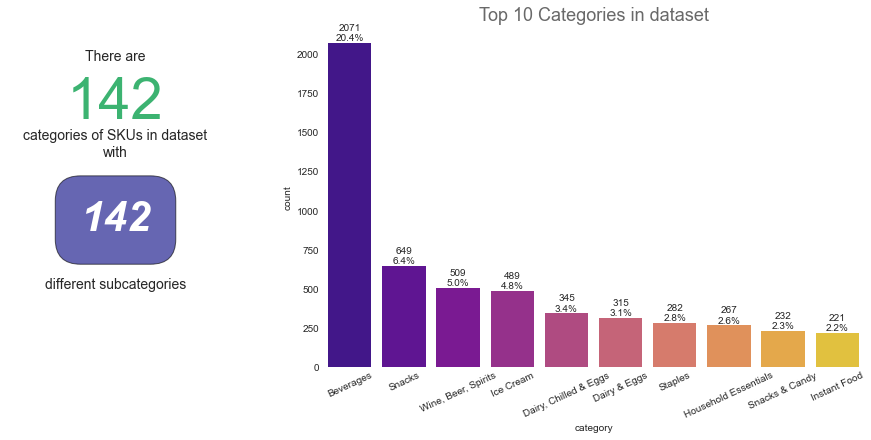

In [17]:
# Building a figure
fig = plt.figure(constrained_layout=True, figsize=(12, 6))

# Axis definition with GridSpec
gs = GridSpec(1, 3, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1:3])

# Axis 1 - Big Number for total categories and subcategories in the data
total_categories = len(df['category'].value_counts())
total_subcategories = len(df['category'].value_counts())
ax1.text(0.4, 0.9, 'There are', fontsize=14, ha='center')
ax1.text(0.4, 0.73, f'{total_categories}', fontsize=58, color='mediumseagreen', ha='center')
ax1.text(0.4, 0.62, f'categories of SKUs in dataset\nwith', fontsize=14, ha='center')
ax1.text(0.4, 0.4, total_subcategories, fontsize=42, ha='center', color='white', style='italic', weight='bold',
         bbox=dict(facecolor='navy', alpha=0.6, pad=16, boxstyle='round, pad=.6'))
ax1.text(0.4, 0.23, 'different subcategories', fontsize=14, ha='center')
ax1.axis('off')

# Axis 2 - Total number of subcategories
top = 10
single_countplot(df, ax2, x='category', top=top)
ax2.set_title(f'Top {top} Categories in dataset', color='dimgrey', size=18)
for tick in ax2.get_xticklabels():
    tick.set_rotation(25)

In [18]:
popular_categories = df.groupby(by='category', as_index=False).agg({'sku': 'count',
                                                                                    'gmv': 'mean',
                                                                                    'qty_sold': 'mean',
                                                                                    'profit': 'mean',
                                                                                    'externally_funded_percentage': 'mean'})
popular_categories.columns = ['category', 'total_skus', 'mean_gmv', 'mean_qty_sold', 'mean_profit', 'mean_supplier_finding']
popular_categories = popular_categories.sort_values(by='mean_qty_sold', ascending=False)
popular_categories = popular_categories.loc[:, ['category', 'total_skus', 'mean_gmv', 'mean_qty_sold', 'mean_profit', 'mean_supplier_finding']]
popular_categories.head()

,category,total_skus,mean_gmv,mean_qty_sold,mean_profit,mean_supplier_finding
56,"Egg, Meat & Fish",31,4117.553226,36.096774,-657.769677,0.000000
138,Water,119,148.597899,23.714286,28.795714,5.042017
49,Dairy Products,29,2583.587241,18.758621,93.524483,5.172414
95,"Meat, Fruits & Vegetables",9,817.532222,12.000000,192.462222,0.000000
72,Fruits & Vegetable,61,430.372787,11.688525,-16.773443,8.475410


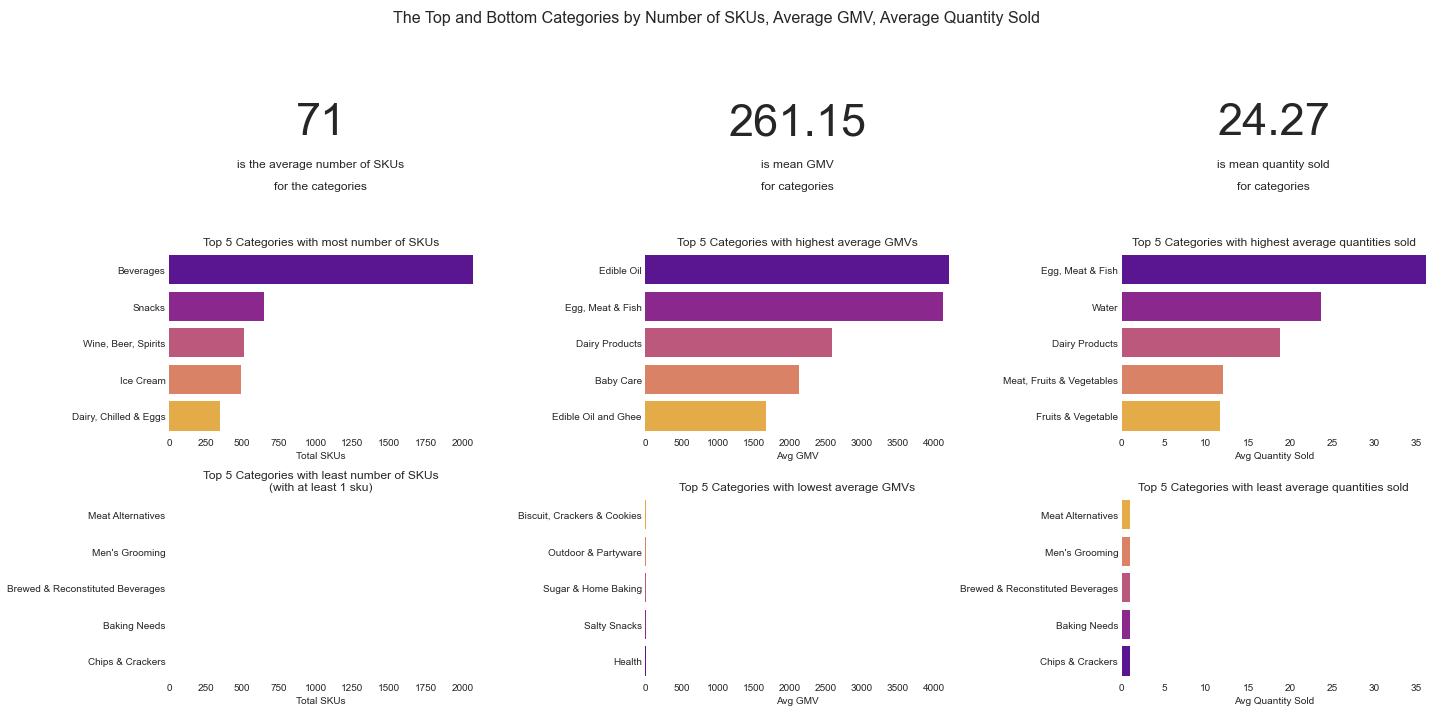

In [19]:
# Creating a figure por restaurants overview analysis
fig, axs = plt.subplots(3,3, figsize=(20, 10))

# Plot Pack 01 - Most Number of SKUs
sns.barplot(x='total_skus', y='category', data=popular_categories.sort_values(by='total_skus', ascending=False).head(),
            ax=axs[1, 0], palette='plasma')
axs[1, 0].set_title('Top 5 Categories with most number of SKUs', size=12)
sns.barplot(x='total_skus', y='category', 
            data=popular_categories.sort_values(by='total_skus', ascending=False).query('total_skus > 0').tail(),
            ax=axs[2, 0], palette='plasma_r')
axs[2, 0].set_title('Top 5 Categories with least number of SKUs\n(with at least 1 sku)', size=12)
for ax in axs[1, 0], axs[2, 0]:
    ax.set_xlabel('Total SKUs')
    ax.set_xlim(0, popular_categories['total_skus'].max())
    format_spines(ax, right_border=False)
    ax.set_ylabel('')

# Annotations
axs[0, 0].text(0.50, 0.30, int(popular_categories.total_skus.mean()), fontsize=45, ha='center')
axs[0, 0].text(0.50, 0.12, 'is the average number of SKUs', fontsize=12, ha='center')
axs[0, 0].text(0.50, 0.00, 'for the categories', fontsize=12, ha='center')
axs[0, 0].axis('off')

# Plot Pack 02 - Mean GMV
sns.barplot(x='mean_gmv', y='category', data=popular_categories.sort_values(by='mean_gmv', ascending=False).head(),
            ax=axs[1, 1], palette='plasma')
axs[1, 1].set_title('Top 5 Categories with highest average GMVs', size=12)
sns.barplot(x='mean_gmv', y='category', 
            data=popular_categories.sort_values(by='mean_gmv', ascending=False).query('mean_gmv > 0').tail(),
            ax=axs[2, 1], palette='plasma_r')
axs[2, 1].set_title('Top 5 Categories with lowest average GMVs', size=12)
for ax in axs[1, 1], axs[2, 1]:
    ax.set_xlabel('Avg GMV')
    ax.set_xlim(0, popular_categories['mean_gmv'].max())
    format_spines(ax, right_border=False)
    ax.set_ylabel('')

# Annotations
axs[0, 1].text(0.50, 0.30, round(popular_categories.mean_gmv.mean(), 2), fontsize=45, ha='center')
axs[0, 1].text(0.50, 0.12, 'is mean GMV', fontsize=12, ha='center')
axs[0, 1].text(0.50, 0.00, 'for categories', fontsize=12, ha='center')
axs[0, 1].axis('off')

# Plot Pack 03 - Quantity Sold
sns.barplot(x='mean_qty_sold', y='category', data=popular_categories.sort_values(by='mean_qty_sold', ascending=False).head(),
            ax=axs[1, 2], palette='plasma')
axs[1, 2].set_title('Top 5 Categories with highest average quantities sold', size=12)
sns.barplot(x='mean_qty_sold', y='category', 
            data=popular_categories.sort_values(by='mean_qty_sold', ascending=False).query('mean_qty_sold > 0').tail(),
            ax=axs[2, 2], palette='plasma_r')
axs[2, 2].set_title('Top 5 Categories with least average quantities sold', size=12)
for ax in axs[1, 2], axs[2, 2]:
    ax.set_xlabel('Avg Quantity Sold')
    ax.set_xlim(0, popular_categories['mean_qty_sold'].max())
    format_spines(ax, right_border=False)
    ax.set_ylabel('')

# Annotations
axs[0, 2].text(0.50, 0.30, round(popular_categories.mean_profit.mean(), 2), fontsize=45, ha='center')
axs[0, 2].text(0.50, 0.12, 'is mean quantity sold', fontsize=12, ha='center')
axs[0, 2].text(0.50, 0.00, 'for categories', fontsize=12, ha='center')
axs[0, 2].axis('off')

plt.tight_layout()
plt.suptitle('The Top and Bottom Categories by Number of SKUs, Average GMV, Average Quantity Sold', size=16)
plt.show()


#### Subcategory Insights

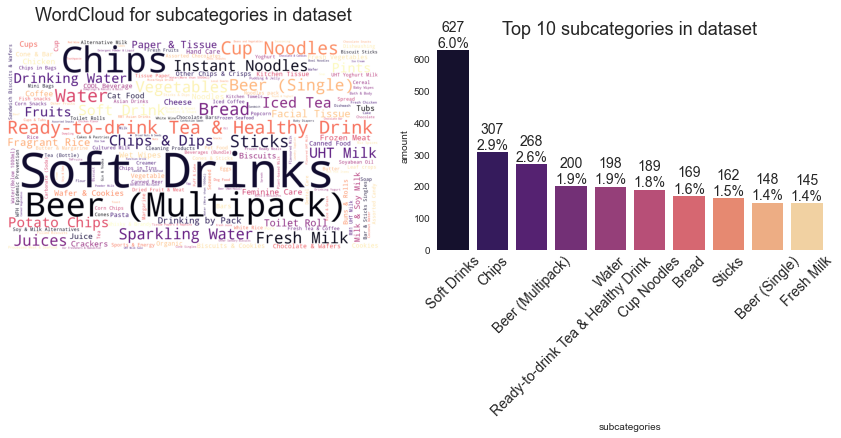

In [20]:
# Creating a list with all options available
from wordcloud import WordCloud 
subcategories = list(df['subcategory'].astype(str).values)
subcategories_word_list = []
for lista in [c.split(',') for c in subcategories]:
    for word in lista:
        subcategories_word_list.append(word.strip())
        
# Creating a Counter for unique options and generating the wordcloud
subcategories_wc_dict = Counter(subcategories_word_list)

wordcloud = WordCloud(width=1280, height=720, collocations=False, random_state=42, 
                      colormap='magma', background_color='white').generate_from_frequencies(subcategories_wc_dict)

# Visualizing the WC created and the total for each subcateogry
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
ax1 = axs[0]
ax2 = axs[1]
ax1.imshow(wordcloud)
ax1.axis('off')
ax1.set_title(f'WordCloud for subcategories in dataset', size=18, pad=20)

# Total for each cuisine
df_subcategories = pd.DataFrame()
df_subcategories['subcategories'] = subcategories_wc_dict.keys()
df_subcategories['amount'] = subcategories_wc_dict.values()
df_subcategories.sort_values(by='amount', ascending=False, inplace=True)
sns.barplot(x='subcategories', y='amount', data=df_subcategories.head(10), palette='magma', ax=ax2)
format_spines(ax2, right_border=False)
ax2.set_title(f'Top 10 subcategories in dataset', size=18)

# Customizing chart
ncount = df_subcategories['amount'].sum()
x_ticks = [item.get_text() for item in ax2.get_xticklabels()]
ax2.set_xticklabels(x_ticks, rotation=45, fontsize=14)
for p in ax2.patches:
    x = p.get_bbox().get_points()[:, 0]
    y = p.get_bbox().get_points()[1, 1]
    ax2.annotate('{}\n{:.1f}%'.format(int(y), 100. * y / ncount), (x.mean(), y), fontsize=14, ha='center', va='bottom')

plt.tight_layout()
plt.show()

#### Boolean Columns

In [21]:
cols_boolean

array(['is_campaign_active'], dtype=object)

In [22]:
# Columns that start with "is"
print(df.filter(regex='^is',axis=1).columns)

Index(['is_campaign_active', 'is_outlier_incremental_quantity',
       'is_outlier_incremental_gmv', 'is_outlier_incremental_profit_ext'],
      dtype='object')


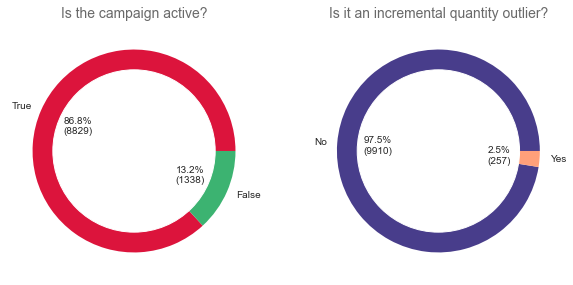

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(10, 10))
donut_plot(df, col='is_campaign_active', colors=['crimson', 'mediumseagreen'], ax=axs[0], 
           title='Is the campaign active?')
donut_plot(df, col='is_outlier_incremental_quantity', colors=['darkslateblue', 'lightsalmon'], ax=axs[1], 
           title='Is it an incremental quantity outlier?')

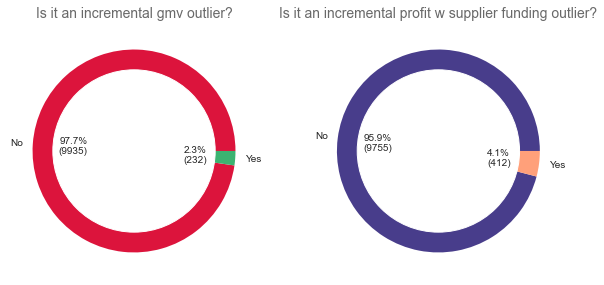

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(10, 10))
donut_plot(df, col='is_outlier_incremental_gmv', colors=['crimson', 'mediumseagreen'], ax=axs[0], 
           title='Is it an incremental gmv outlier?')
donut_plot(df, col='is_outlier_incremental_profit_ext', colors=['darkslateblue', 'lightsalmon'], ax=axs[1], 
           title='Is it an incremental profit w supplier funding outlier?')

### Numerical Columns

In [25]:
# Add number of campaign days to colums_numeric
cols_numeric = np.append(cols_numeric,['number_of_campaign_days'])

# Look at values based on percentiles
desc = df.loc[:, cols_numeric].describe(percentiles=[0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
for col in desc.columns:
    desc[col] = np.round(desc[col], 2)
    
u.display_df(desc)

,no_of_campaigns,y_pred_base,y_pred,b_qty,qty_sold,incremental_quantity_tab,price_base,price,cost,b_gmv,gmv,incremental_gmv_tab,b_profit,profit,profit_ext,incremental_profit_ext_tab,discount,externally_funded_percentage,number_of_campaign_days
count,10167.00,10167.00,10167.00,10167.00,10167.00,10167.00,10167.00,10167.00,10167.00,10167.00,10167.00,10167.00,10167.00,10167.00,10167.00,10165.00,10167.00,10167.00,10167.00
mean,1.72,3.86,5.67,3.93,5.74,51.71,39.47,34.07,29.21,143.73,182.30,24.93,32.16,18.84,26.76,-3.80,14.97,52.27,80.26
std,1.30,4.87,7.53,5.89,9.11,90.15,91.91,82.47,68.71,648.68,916.25,40.24,95.44,126.12,133.16,175.67,9.53,45.81,1308.18
min,1.00,0.10,0.43,0.06,1.00,1.21,0.09,0.07,0.06,0.20,0.33,0.00,-835.83,-7780.92,-7780.92,-5834.84,1.00,0.00,0.00
1%,1.00,0.77,1.22,0.44,1.00,5.54,1.10,0.88,0.76,1.08,1.39,0.22,0.23,-44.59,-27.65,-316.40,2.00,0.00,0.00
5%,1.00,1.12,1.54,0.63,1.00,10.50,1.50,1.30,1.13,2.74,3.40,1.33,0.63,-3.85,-0.39,-113.96,4.00,0.00,1.00
10%,1.00,1.29,1.75,0.73,1.00,13.64,2.20,1.84,1.60,4.55,5.40,2.89,1.09,-0.55,0.48,-73.02,5.00,0.00,3.00
25%,1.00,1.68,2.33,0.97,2.00,21.65,5.37,4.46,3.86,11.19,13.50,7.24,2.66,0.72,2.10,-23.43,9.00,0.00,6.00
50%,1.00,2.45,3.53,2.20,3.00,35.14,15.00,13.00,10.96,32.65,39.80,15.40,7.84,3.77,7.62,10.00,13.00,74.00,10.00
75%,2.00,4.10,6.12,4.36,6.00,58.73,37.45,32.69,26.85,103.57,127.50,29.47,25.46,16.46,24.55,31.08,20.00,100.00,21.00


#### Numerical Distributions

In [ ]:
sns.pairplot(df, vars = ['incremental_gmv_tab','incremental_quantity_tab','incremental_profit_ext_tab','discount','externally_funded_percentage'], 
             kind = 'reg',
             diag_kws = {'color': 'lightsalmon'},
             plot_kws = {'ci':None, 'color': 'gray',
                        'scatter_kws': {'color':'skyblue', 's':1}
                        }
            
            );

#### Boxplots & Histplots for the entire dataset

,incremental_gmv_tab,incremental_quantity_tab,incremental_profit_ext_tab
count,10167.00,10167.00,10165.00
mean,24.93,51.71,-3.80
std,40.24,90.15,175.67
min,0.00,1.21,-5834.84
0%,0.00,1.21,-5834.84
25%,7.24,21.65,-23.43
50%,15.40,35.14,10.00
75%,29.47,58.73,31.08
100%,1079.38,4213.73,5689.47
max,1079.38,4213.73,5689.47


None

Text(0.5, 0, 'Distribution of Incremental Profit')

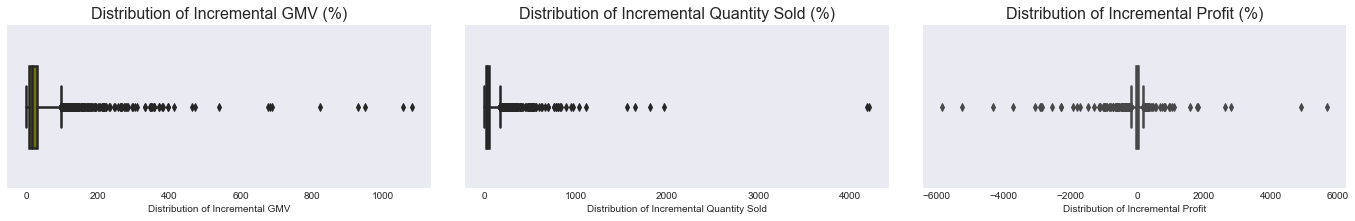

In [115]:
desc = df[['incremental_gmv_tab','incremental_quantity_tab','incremental_profit_ext_tab']].describe(percentiles=[0, 0.25, 0.5, 0.75, 1])
for col in desc.columns:
    desc[col] = np.round(desc[col], 2)
    
display(u.display_df(desc))

fig, ax = plt.subplots(1,3, figsize = (24,3), sharey=False)
plt.subplots_adjust(wspace = 0.08)

# GMV
sns.boxplot(x = 'incremental_gmv_tab', data = df, ax = ax[0], color = 'olive', whis = 3, width = 0.5, linewidth = 2.5)
ax[0].set_title('Distribution of Incremental GMV (%)', fontsize = 16)
ax[0].set_xlabel('Distribution of Incremental GMV')

# Quantity Sold
sns.boxplot(x = 'incremental_quantity_tab', data = df, ax = ax[1], color = 'teal', whis = 3, width = 0.5, linewidth = 2.5)
ax[1].set_title('Distribution of Incremental Quantity Sold (%)', fontsize = 16)
ax[1].set_xlabel('Distribution of Incremental Quantity Sold')

# Quantity Sold
sns.boxplot(x = 'incremental_profit_ext_tab', data = df, ax = ax[2], color = 'crimson', whis = 3, width = 0.5, linewidth = 2.5)
ax[2].set_title('Distribution of Incremental Profit (%)', fontsize = 16)
ax[2].set_xlabel('Distribution of Incremental Profit')



In [112]:
# GMV
sns.histplot(x = 'incremental_gmv_tab', data = df, ax = ax[0], color = 'olive', kde = True)
ax[0].set_title('Distribution of Incremental GMV (%)', fontsize = 16)
ax[0].set_xlabel('Distribution of Incremental GMV')

# Quantity Sold
sns.histplot(x = 'incremental_quantity_tab', data = df, ax = ax[1], color = 'teal', kde = True)
ax[1].set_title('Distribution of Incremental Quantity Sold (%)', fontsize = 16)
ax[1].set_xlabel('Distribution of Incremental Quantity Sold')

# Quantity Sold
sns.histplot(x = 'incremental_profit_ext_tab', data = df, ax = ax[2], color = 'crimson', kde = True)
ax[2].set_title('Distribution of Incremental Profit (%)', fontsize = 16)
ax[2].set_xlabel('Distribution of Incremental Profit');

In [107]:
desc = df[['incremental_gmv_tab','incremental_quantity_tab','incremental_profit_ext_tab']].describe(percentiles=[0, 0.25, 0.5, 0.75, 1])
for col in desc.columns:
    desc[col] = np.round(desc[col], 2)
    
u.display_df(desc)

,incremental_gmv_tab,incremental_quantity_tab,incremental_profit_ext_tab
count,10167.00,10167.00,10165.00
mean,24.93,51.71,-3.80
std,40.24,90.15,175.67
min,0.00,1.21,-5834.84
0%,0.00,1.21,-5834.84
25%,7.24,21.65,-23.43
50%,15.40,35.14,10.00
75%,29.47,58.73,31.08
100%,1079.38,4213.73,5689.47
max,1079.38,4213.73,5689.47


In [29]:
df.columns

Index(['order_date', 'global_entity_id', 'warehouse', 'supplier', 'sku',
       'no_of_campaigns', 'campaign_id', 'campaign_name',
       'campaign_created_time_utc', 'campaign_start_time_utc',
       'campaign_end_time_utc', 'is_campaign_active', 'category',
       'subcategory', 'brand', 'product', 'y_pred_base', 'y_pred', 'b_qty',
       'qty_sold', 'incremental_quantity_tab',
       'is_outlier_incremental_quantity', 'price_base', 'price', 'cost',
       'b_gmv', 'gmv', 'incremental_gmv_tab', 'is_outlier_incremental_gmv',
       'b_profit', 'profit', 'profit_ext', 'incremental_profit_ext_tab',
       'is_outlier_incremental_profit_ext', 'execution_date', 'confidence',
       'discount', 'externally_funded_percentage', 'number_of_campaign_days'],
      dtype='object')

## Numerical Distributions by global entity id

In [30]:
# Numerical Columns
numerical_columns = df._get_numeric_data().columns
print(numerical_columns)

Index(['no_of_campaigns', 'is_campaign_active', 'y_pred_base', 'y_pred',
       'b_qty', 'qty_sold', 'incremental_quantity_tab', 'price_base', 'price',
       'cost', 'b_gmv', 'gmv', 'incremental_gmv_tab', 'b_profit', 'profit',
       'profit_ext', 'incremental_profit_ext_tab', 'discount',
       'externally_funded_percentage', 'number_of_campaign_days'],
      dtype='object')


In [31]:
# Choose Columns
category_col = ['global_entity_id']
cols_of_interest = ['no_of_campaigns','y_pred_base', 'y_pred',
       'b_qty', 'qty_sold', 'incremental_quantity_tab', 'price_base', 'price',
       'cost', 'b_gmv', 'gmv', 'incremental_gmv_tab', 'b_profit', 'profit',
       'profit_ext', 'incremental_profit_ext_tab', 'discount',
       'externally_funded_percentage', 'number_of_campaign_days']
# Loop through Columns
for cols in cols_of_interest:
    display(df.groupby(category_col)[cols].describe(percentiles=[0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]).sort_values(by=['mean'], ascending = False).rename_axis(cols)\
                                                                                                                    .style.format({"count": "{0:.0f}", 
                                                                                                                          "mean": "{0:.2f}", 
                                                                                                                          "std": "{0:.2f}",
                                                                                                                          "min":"{0:.2f}",
                                                                                                                           "1%": "{0:.2f}",
                                                                                                                           "5%": "{0:.2f}",
                                                                                                                          "10%": "{0:.2f}",
                                                                                                                          "25%": "{0:.2f}",
                                                                                                                          "50%": "{0:.2f}",
                                                                                                                          "75%": "{0:.2f}",
                                                                                                                          "90%": "{0:.2f}",
                                                                                                                          "95%": "{0:.2f}",
                                                                                                                         "95%": "{0:.2f}",
                                                                                                                         "99%": "{0:.2f}",
                                                                                                                          "max": "{0:.2f}"})\
                                                                                                                       .background_gradient(cmap='Blues'))

    

,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
no_of_campaigns,,,,,,,,,,,,,,
FP_BD,552,2.10,1.35,1.00,1.00,1.00,1.00,1.00,2.00,3.00,4.00,5.00,6.00,8.00
HF_EG,274,2.06,4.71,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,2.35,24.00,24.00
FP_TW,1310,2.03,1.57,1.00,1.00,1.00,1.00,1.00,1.00,2.00,4.00,5.00,8.00,11.00
FP_SG,2243,1.90,0.93,1.00,1.00,1.00,1.00,1.00,2.00,2.00,3.00,4.00,5.00,8.00
TB_BH,13,1.77,1.09,1.00,1.00,1.00,1.00,1.00,1.00,2.00,3.60,4.00,4.00,4.00
FP_HK,1454,1.71,1.00,1.00,1.00,1.00,1.00,1.00,1.00,2.00,3.00,4.00,5.00,11.00
FP_PK,468,1.69,0.99,1.00,1.00,1.00,1.00,1.00,1.00,2.00,3.00,4.00,5.00,9.00
PO_FI,12,1.67,1.07,1.00,1.00,1.00,1.00,1.00,1.00,2.25,3.00,3.45,3.89,4.00
TB_AE,548,1.66,0.94,1.00,1.00,1.00,1.00,1.00,1.00,2.00,3.00,3.00,5.00,6.00


,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
y_pred_base,,,,,,,,,,,,,,
TB_BH,13,7.88,10.81,0.59,0.75,1.38,1.90,1.96,2.58,8.88,21.97,29.61,35.23,36.64
FP_PK,468,5.54,8.37,0.36,0.69,1.07,1.24,1.74,2.82,4.84,12.32,22.00,44.95,74.69
PO_FI,12,5.11,4.82,0.86,0.96,1.37,1.81,2.05,2.67,7.11,10.67,13.59,16.21,16.87
TB_AE,548,4.67,5.09,0.58,0.95,1.16,1.31,1.70,2.63,5.22,11.13,14.54,24.63,39.31
FP_BD,552,4.63,7.71,0.10,0.28,0.69,0.92,1.35,2.44,4.50,8.92,14.12,38.65,83.40
FP_TH,1269,4.00,6.23,0.44,0.90,1.10,1.24,1.54,2.19,3.70,7.18,13.37,32.93,74.85
FP_SG,2243,3.94,4.57,0.24,0.86,1.14,1.31,1.70,2.47,4.55,8.10,10.52,20.10,88.46
HF_EG,274,3.86,6.06,0.79,0.82,1.08,1.27,1.63,2.29,3.91,6.83,11.19,24.45,79.55
HS_SA,639,3.66,2.95,0.72,1.04,1.26,1.41,1.75,2.75,4.72,7.03,8.49,14.63,27.81


,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
y_pred,,,,,,,,,,,,,,
TB_BH,13,20.87,37.92,2.70,2.73,2.86,2.97,3.36,5.44,22.69,33.34,77.30,128.84,141.73
PO_FI,12,7.98,5.43,2.50,2.61,3.06,3.52,4.06,6.23,10.01,15.35,17.89,19.87,20.37
FP_BD,552,7.51,14.10,0.43,0.91,1.25,1.52,2.17,3.92,7.07,13.81,23.83,67.65,162.68
FP_PK,468,7.27,10.30,1.12,1.18,1.47,1.64,2.35,3.61,7.14,16.28,28.69,55.08,79.06
TB_AE,548,7.03,8.06,0.73,1.28,1.62,1.83,2.55,4.13,7.96,15.87,22.88,37.89,85.45
HF_EG,274,6.62,11.16,1.22,1.34,1.67,1.87,2.39,3.71,5.47,11.08,23.18,56.92,109.80
FP_TH,1269,5.62,9.25,0.94,1.21,1.43,1.62,2.01,3.02,5.22,10.25,18.44,45.87,113.59
FP_SG,2243,5.57,6.42,0.75,1.21,1.51,1.69,2.25,3.39,6.54,11.88,15.85,30.11,113.52
HS_SA,639,5.16,4.45,1.08,1.34,1.61,1.81,2.31,3.76,6.48,10.07,12.27,21.86,42.75


,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
b_qty,,,,,,,,,,,,,,
TB_BH,13,9.83,16.42,0.47,0.49,0.58,0.68,1.13,2.15,10.23,22.29,38.10,54.98,59.20
FP_PK,468,5.51,10.00,0.29,0.44,0.62,0.73,0.96,2.40,5.25,12.45,20.80,51.93,83.31
PO_FI,12,5.38,7.34,0.73,0.73,0.74,0.76,1.31,2.42,7.73,8.92,16.84,24.58,26.51
TB_AE,548,5.04,6.65,0.20,0.51,0.65,0.76,1.34,2.46,5.50,12.68,19.48,31.48,45.46
FP_BD,552,4.96,10.23,0.11,0.23,0.43,0.53,0.80,1.90,4.82,10.87,17.80,49.00,132.72
FP_TH,1269,3.99,6.67,0.34,0.56,0.70,0.74,0.89,1.94,3.99,8.31,14.91,35.30,92.24
FP_SG,2243,3.97,5.33,0.06,0.54,0.68,0.76,1.12,2.33,4.64,8.70,12.46,26.42,70.31
HS_SA,639,3.85,4.18,0.37,0.59,0.73,0.80,1.32,2.37,4.87,8.74,12.36,21.46,27.00
HF_EG,274,3.75,6.38,0.39,0.42,0.55,0.62,0.80,1.73,3.85,7.24,13.79,24.97,60.86


,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
qty_sold,,,,,,,,,,,,,,
TB_BH,13,30.54,64.46,1.00,1.00,1.00,1.20,2.00,6.00,16.00,78.00,147.40,212.68,229.00
FP_BD,552,7.94,17.82,1.00,1.00,1.00,1.00,1.00,3.00,7.00,17.00,27.00,88.92,231.00
PO_FI,12,7.83,8.56,2.00,2.00,2.00,2.00,2.75,4.00,10.50,12.90,21.55,29.91,32.00
TB_AE,548,7.49,9.84,1.00,1.00,1.00,1.00,2.00,4.00,8.00,18.30,30.00,43.59,82.00
FP_PK,468,7.23,12.46,1.00,1.00,1.00,1.00,2.00,3.00,7.00,15.00,30.00,68.66,108.00
HF_EG,274,6.36,12.05,1.00,1.00,1.00,1.00,1.00,3.00,6.00,12.00,22.45,65.02,96.00
FP_SG,2243,5.60,7.63,1.00,1.00,1.00,1.00,2.00,3.00,6.00,12.00,18.00,39.00,102.00
FP_TH,1269,5.57,9.45,1.00,1.00,1.00,1.00,1.00,3.00,6.00,11.00,21.00,48.32,134.00
HS_SA,639,5.38,5.96,1.00,1.00,1.00,1.00,2.00,3.00,7.00,12.00,18.00,29.62,46.00


,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
incremental_quantity_tab,,,,,,,,,,,,,,
TB_BH,13,146.73,141.40,17.30,17.33,17.46,17.87,48.51,76.99,286.82,349.46,384.20,407.10,412.82
PO_FI,12,97.98,83.54,13.12,13.96,17.30,22.72,44.39,64.27,133.41,168.04,233.58,295.48,310.96
FP_BD,552,79.61,113.83,2.04,5.26,11.11,14.95,23.91,45.39,92.31,163.16,252.94,798.12,1114.29
FP_MY,1385,68.04,179.52,1.78,7.53,12.99,16.28,26.58,41.84,66.67,117.39,163.16,496.97,4213.73
HF_EG,274,61.86,60.58,6.38,12.59,16.28,21.70,30.43,48.33,75.44,116.52,141.85,294.77,704.02
TB_AE,548,55.07,54.66,1.27,7.50,14.20,18.84,26.45,38.38,65.02,96.08,132.91,292.16,625.08
FP_TW,1310,53.57,67.35,1.27,5.27,9.89,13.62,21.95,39.79,61.29,102.02,124.34,363.19,837.50
FP_HK,1454,53.20,91.36,1.87,6.05,9.89,13.64,21.03,34.23,61.29,101.05,131.07,257.14,1968.97
FP_SG,2243,41.95,46.22,2.04,6.38,11.02,13.21,20.48,31.58,52.91,81.76,100.13,160.32,1566.67


,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
price_base,,,,,,,,,,,,,,
FP_PK,468,182.57,279.19,15.00,20.00,30.00,42.00,60.00,110.00,180.00,360.00,480.00,1599.00,3190.00
FP_BD,552,143.64,187.91,10.00,11.02,17.00,22.00,35.00,61.50,153.50,359.00,609.00,728.00,1295.00
FP_TW,1310,79.61,59.12,10.00,15.00,20.00,25.90,34.00,64.50,107.25,158.00,189.00,299.00,499.00
FP_TH,1269,43.52,34.53,10.00,10.00,15.00,18.00,22.00,30.00,56.00,79.00,117.00,205.40,287.00
FP_HK,1454,22.53,18.19,3.90,4.00,6.00,7.50,10.83,15.90,26.90,43.90,59.31,97.90,112.90
HF_EG,274,14.91,16.65,1.95,1.95,2.75,3.95,5.50,10.45,16.49,26.65,52.95,83.95,134.95
TB_AE,548,12.85,8.46,1.25,1.75,2.97,3.92,6.95,10.75,18.00,22.50,29.80,48.11,50.14
HS_SA,639,9.77,7.66,0.50,1.04,1.25,2.00,4.25,7.25,12.95,22.05,24.95,30.25,44.95
FP_SG,2243,8.13,10.25,0.55,0.90,1.25,1.50,2.08,4.45,11.45,16.90,27.72,55.00,88.00


,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
price,,,,,,,,,,,,,,
FP_PK,468,161.97,252.60,12.00,16.00,27.00,38.70,53.56,99.00,157.00,300.00,448.63,1399.00,2831.00
FP_BD,552,127.73,174.17,5.00,9.50,15.00,18.34,30.08,53.76,145.32,319.00,526.75,702.90,1174.59
FP_TW,1310,66.01,47.18,5.00,10.00,17.00,21.00,28.00,55.00,85.00,137.01,166.00,204.64,419.00
FP_TH,1269,38.44,30.38,5.00,9.00,13.00,15.00,20.00,26.00,49.00,75.73,99.00,159.00,279.00
FP_HK,1454,19.07,15.24,0.99,3.50,4.90,6.00,9.00,14.00,24.15,35.90,49.00,88.89,107.43
HF_EG,274,12.41,14.50,1.61,1.65,1.94,2.95,4.25,8.44,13.89,21.95,45.95,74.12,125.95
TB_AE,548,9.83,6.59,0.98,1.16,2.25,2.93,5.23,8.42,13.95,15.00,24.15,37.37,38.99
HS_SA,639,8.17,6.70,0.45,0.66,1.06,1.74,3.18,6.07,10.79,19.51,22.05,26.55,38.20
FP_SG,2243,7.05,9.03,0.45,0.76,1.00,1.26,1.81,3.80,9.84,15.39,22.95,49.50,83.00


,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
cost,,,,,,,,,,,,,,
FP_PK,468,131.18,189.50,8.32,11.11,19.69,30.49,39.39,80.72,133.51,254.74,363.91,1132.32,1859.48
FP_BD,552,123.23,162.07,7.54,8.58,12.95,18.25,30.00,51.10,135.00,313.86,513.75,669.93,973.90
FP_TW,1310,51.68,38.29,5.62,7.14,11.68,15.55,22.60,45.40,64.76,104.57,135.00,185.33,255.00
FP_TH,1269,34.62,27.19,2.75,8.04,11.95,14.30,18.70,23.97,44.21,66.64,87.48,178.07,231.55
FP_HK,1454,15.56,13.31,2.30,2.70,3.86,4.54,7.20,11.10,19.18,31.00,37.20,86.67,101.10
HF_EG,274,11.60,13.71,1.23,1.42,1.89,2.58,4.19,8.63,13.32,21.82,40.02,64.39,125.44
TB_AE,548,8.78,5.90,0.65,0.80,1.91,2.63,4.69,7.38,14.00,14.93,20.44,31.68,33.25
HS_SA,639,6.66,5.37,0.33,0.71,0.82,1.34,2.75,4.80,9.00,15.39,17.14,22.14,32.49
FP_SG,2243,6.39,8.35,0.28,0.66,0.95,1.07,1.70,3.22,8.10,14.72,22.94,42.66,75.37


,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
b_gmv,,,,,,,,,,,,,,
FP_PK,468,648.14,1272.69,10.64,22.99,54.33,71.91,134.43,271.44,722.21,1416.96,2052.56,6348.13,18160.23
FP_BD,552,637.69,2251.61,2.19,9.79,17.04,27.54,56.19,154.99,454.24,1319.99,2331.68,8180.82,41731.85
FP_TW,1310,271.26,401.85,7.39,15.07,24.68,35.48,73.93,145.72,296.32,554.60,943.42,2243.84,3491.33
FP_TH,1269,165.17,333.99,3.41,10.97,14.89,19.30,35.63,68.32,152.90,348.84,610.39,1473.49,5534.41
FP_HK,1454,65.81,84.47,2.05,4.32,7.25,10.31,19.39,38.62,74.89,151.02,214.44,430.30,804.61
TB_AE,548,55.58,72.80,1.38,2.25,4.53,6.55,13.00,26.95,67.50,136.49,208.52,358.26,488.73
HF_EG,274,41.79,59.29,1.08,2.21,3.60,5.03,8.95,17.59,48.18,107.86,162.54,264.95,429.25
HS_SA,639,34.46,57.69,0.42,1.09,3.11,4.37,8.59,17.93,37.32,70.45,122.12,297.61,626.04
FP_SG,2243,25.26,45.43,0.38,0.94,1.58,2.50,5.14,11.19,26.49,56.15,92.49,229.04,753.61


,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
gmv,,,,,,,,,,,,,,
FP_BD,552,906.70,3408.57,5.00,14.51,29.55,40.00,84.00,216.00,584.09,1783.80,3205.80,12609.24,64728.00
FP_PK,468,772.47,1410.68,12.00,25.94,65.00,80.92,155.50,321.15,828.19,1804.00,2718.00,6756.35,18260.00
FP_TW,1310,329.93,491.64,10.00,19.00,30.00,45.00,89.00,177.00,360.00,685.35,1080.00,2688.00,4746.72
FP_TH,1269,208.70,437.91,8.00,12.51,17.00,21.97,42.00,84.00,189.00,458.40,812.00,2012.00,6968.00
FP_HK,1454,83.18,110.06,3.50,4.90,9.00,12.80,24.00,45.00,99.60,186.86,281.16,572.83,988.20
TB_AE,548,62.39,79.85,1.56,2.69,4.97,7.58,15.00,30.40,75.00,152.46,228.17,379.21,553.04
HF_EG,274,53.69,78.68,1.65,2.88,4.42,6.49,10.95,23.84,60.94,153.58,224.96,314.83,699.16
HS_SA,639,38.74,65.33,0.45,1.29,3.37,4.76,9.54,19.68,41.61,81.54,135.57,331.73,689.40
FP_SG,2243,30.83,57.55,0.55,1.12,1.95,2.98,6.00,13.12,31.82,71.40,114.33,287.02,916.30


,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
incremental_gmv_tab,,,,,,,,,,,,,,
TB_BH,13,83.18,99.42,2.94,3.50,5.74,7.83,14.87,41.38,106.31,181.26,262.86,338.29,357.14
PO_FI,12,54.27,75.10,2.82,3.46,6.02,8.64,11.81,33.32,52.31,99.34,180.56,255.91,274.74
FP_BD,552,49.28,71.97,0.22,0.52,1.90,4.63,12.25,29.21,62.36,110.45,153.22,358.39,928.84
FP_MY,1385,31.11,59.25,0.00,0.29,1.72,3.46,9.11,18.60,35.00,62.08,88.68,224.18,1079.38
HF_EG,274,29.02,31.91,0.00,1.46,3.26,4.53,9.34,18.79,39.06,59.71,93.83,132.91,310.12
FP_HK,1454,26.64,42.97,0.00,0.29,1.77,3.06,7.45,16.70,32.79,56.18,74.19,157.07,949.53
FP_TW,1310,25.55,41.98,0.05,0.16,0.93,2.04,6.85,15.33,28.30,54.71,79.77,153.59,676.96
FP_TH,1269,22.04,20.88,0.00,0.49,2.57,4.92,8.98,15.96,28.35,44.28,56.39,100.53,193.26
FP_PK,468,22.03,28.22,0.07,0.40,0.97,1.93,5.10,11.42,26.79,55.46,85.76,140.79,159.98


,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
b_profit,,,,,,,,,,,,,,
FP_PK,468,150.68,227.55,-0.77,4.70,9.59,15.12,32.87,71.23,166.91,352.55,580.84,1012.02,2051.77
FP_TW,1310,88.99,131.06,1.31,4.60,8.77,11.61,23.36,46.60,101.76,199.40,307.22,665.88,1582.59
FP_BD,552,62.69,206.44,-835.83,-7.84,2.57,3.92,8.44,20.08,62.28,146.19,221.44,562.74,4058.54
FP_TH,1269,31.11,67.04,-0.65,2.03,2.50,3.25,6.31,13.28,28.75,66.12,101.70,291.53,1125.33
FP_HK,1454,19.77,27.53,0.51,1.33,2.16,3.08,5.50,11.09,22.40,43.80,67.33,149.47,342.39
TB_AE,548,18.58,25.85,-3.38,0.31,1.06,1.75,3.68,8.38,20.60,55.29,79.80,123.00,142.75
HS_SA,639,10.92,17.33,0.14,0.33,1.03,1.37,2.62,5.59,11.86,25.89,37.08,88.94,171.15
HF_EG,274,10.19,18.59,-94.92,0.13,0.57,0.86,1.62,3.99,10.98,29.27,47.92,74.89,143.63
FP_SG,2243,4.95,7.09,-8.62,0.19,0.37,0.60,1.20,2.63,5.94,11.06,17.92,32.49,98.04


,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
profit,,,,,,,,,,,,,,
FP_PK,468,121.35,229.43,-582.66,-107.71,-1.12,3.10,18.02,53.07,138.00,305.58,479.04,1082.67,2417.04
FP_TW,1310,64.33,102.80,-336.82,-47.70,0.53,5.79,15.00,32.95,75.33,150.42,242.44,528.91,975.00
FP_TH,1269,16.74,49.51,-534.38,-42.09,-6.10,-0.34,1.94,7.18,19.28,46.96,71.72,190.11,619.20
FP_HK,1454,14.28,25.07,-188.87,-13.31,0.00,1.21,3.23,7.40,16.90,34.14,54.74,122.21,318.00
TB_AE,548,7.89,19.74,-86.92,-43.09,-9.47,-1.81,0.78,3.20,10.05,27.03,46.32,85.27,126.54
HS_SA,639,6.87,15.44,-55.20,-15.84,-1.16,0.00,0.94,3.10,7.67,18.04,28.69,63.58,160.65
HF_EG,274,4.35,17.47,-145.62,-26.31,-2.72,-1.10,0.01,1.04,4.85,16.51,28.00,57.82,152.04
FP_SG,2243,2.38,5.86,-61.20,-9.07,-2.04,-0.45,0.33,1.20,3.20,7.26,10.71,21.00,94.50
PO_FI,12,2.03,3.48,-2.22,-2.06,-1.41,-0.67,0.34,1.18,2.02,6.39,8.47,10.17,10.60


,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
profit_ext,,,,,,,,,,,,,,
FP_PK,468,133.26,241.07,-582.66,-85.58,0.00,5.69,24.21,59.23,142.94,329.54,505.93,1170.95,2417.04
FP_TW,1310,64.36,102.78,-336.82,-47.70,0.53,5.81,15.00,33.08,75.33,150.42,242.44,528.91,975.00
FP_TH,1269,43.20,108.16,-258.38,-0.84,2.98,3.96,7.62,16.36,37.68,88.02,139.67,623.48,1474.00
FP_HK,1454,24.71,39.48,-188.87,-0.07,2.41,3.32,6.59,12.84,27.86,54.00,87.29,181.69,531.25
HS_SA,639,13.43,21.91,-17.88,-2.34,0.84,1.41,3.14,6.60,14.71,31.60,47.92,114.51,214.65
TB_AE,548,9.88,21.61,-86.92,-43.09,-5.27,-0.45,1.28,3.96,12.63,32.71,48.62,103.79,151.68
TB_BH,13,6.57,16.48,0.00,0.01,0.04,0.08,0.20,0.43,0.70,18.87,36.85,53.17,57.25
FP_SG,2243,5.16,8.19,-37.40,-4.26,0.02,0.36,1.06,2.52,6.25,12.60,19.41,37.32,94.50
FP_MY,1385,4.45,8.48,-11.00,-3.93,-0.84,0.00,0.72,1.93,5.04,10.93,17.50,40.89,121.96


,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
incremental_profit_ext_tab,,,,,,,,,,,,,,
TB_BH,12,158.37,144.23,17.24,17.48,18.45,21.50,50.38,95.83,286.83,354.07,390.10,418.02,425.00
FP_TH,1269,29.86,47.68,-419.88,-113.73,-3.84,6.06,15.02,26.26,43.18,63.83,84.09,186.01,485.26
FP_HK,1454,25.10,168.16,-5244.44,-101.06,-45.83,-23.20,6.74,25.87,48.74,84.91,122.90,218.07,1830.71
HS_SA,639,24.29,56.65,-237.50,-205.25,-40.90,-24.18,9.78,23.38,40.00,68.79,90.03,220.06,443.52
FP_SG,2243,5.04,60.73,-781.82,-230.83,-96.18,-50.84,-11.30,13.64,31.58,57.14,80.50,129.86,250.00
FP_MY,1385,3.11,133.48,-1000.00,-228.26,-153.86,-100.00,-15.97,11.56,29.41,52.10,77.33,238.51,2823.08
FP_PK,468,-24.23,165.23,-2846.94,-272.11,-99.90,-75.29,-31.10,-12.72,3.37,24.93,41.11,73.99,1588.31
FP_TW,1310,-27.04,61.59,-1108.32,-247.82,-99.32,-72.16,-38.39,-16.94,-5.03,10.49,27.29,58.57,264.54
TB_AE,548,-67.72,173.86,-3040.00,-625.94,-288.18,-117.44,-76.33,-43.29,-16.84,10.53,43.21,109.36,308.28


,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
discount,,,,,,,,,,,,,,
TB_AE,548,22.72,11.10,1.00,4.47,8.00,10.00,15.00,20.00,30.00,34.00,44.00,60.42,67.00
TB_BH,13,21.31,14.68,2.00,2.72,5.60,8.40,10.00,20.00,31.00,44.60,47.00,47.00,47.00
PO_FI,12,21.17,13.23,8.00,8.11,8.55,9.10,10.75,14.00,34.75,40.00,40.00,40.00,40.00
HF_EG,274,18.30,8.36,1.00,3.73,7.00,9.00,12.00,18.00,23.75,28.70,32.00,43.16,51.00
HS_SA,639,17.85,10.70,1.00,2.00,5.00,7.00,10.00,15.00,23.00,32.00,40.00,50.00,60.00
FP_MY,1385,17.13,9.21,1.00,5.00,5.00,9.00,10.00,15.00,23.00,26.00,33.00,50.00,73.00
FP_TW,1310,15.91,11.07,1.00,2.00,4.00,6.00,8.00,12.00,20.00,32.10,40.00,50.00,64.00
FP_HK,1454,14.46,9.14,1.00,3.00,4.00,5.00,9.00,12.00,18.00,27.00,32.35,46.00,87.00
FP_SG,2243,13.42,7.63,1.00,3.00,4.00,5.00,8.00,12.00,18.00,22.00,26.00,41.16,50.00


,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
externally_funded_percentage,,,,,,,,,,,,,,
TB_BH,13,100.00,0.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00
FP_TH,1269,90.51,25.60,0.00,0.00,0.00,80.00,97.50,100.00,100.00,100.00,100.00,100.00,100.00
HS_SA,639,79.07,38.93,0.00,0.00,0.00,0.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00
FP_HK,1454,73.52,43.90,0.00,0.00,0.00,0.00,0.00,100.00,100.00,100.00,100.00,100.00,100.00
FP_SG,2243,62.98,41.44,0.00,0.00,0.00,0.00,5.50,80.00,100.00,100.00,100.00,100.00,100.00
FP_MY,1385,60.82,31.86,0.00,0.00,0.00,0.00,50.00,79.00,80.00,87.00,100.00,100.00,100.00
FP_BD,552,32.53,46.28,0.00,0.00,0.00,0.00,0.00,0.00,100.00,100.00,100.00,100.00,100.00
TB_AE,548,15.36,32.01,0.00,0.00,0.00,0.00,0.00,0.00,2.00,76.30,100.00,100.00,100.00
FP_PK,468,12.59,26.32,0.00,0.00,0.00,0.00,0.00,0.00,0.00,50.00,50.00,100.00,100.00


,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
number_of_campaign_days,,,,,,,,,,,,,,
FP_TW,1310,515.35,3615.24,0.00,0.00,0.00,1.00,3.00,11.50,102.00,239.00,247.00,28821.00,28821.00
TB_AE,548,36.57,66.83,0.00,0.00,1.00,2.00,5.00,10.00,26.00,211.00,216.85,220.00,274.00
FP_BD,552,22.80,14.77,0.00,0.00,2.00,5.00,11.00,26.00,30.00,31.00,45.35,68.80,151.00
FP_PK,468,18.70,19.50,0.00,0.00,1.00,2.00,6.00,13.00,25.00,38.00,61.00,89.82,126.00
FP_SG,2243,16.59,16.52,0.00,1.00,3.00,5.00,7.00,7.00,28.00,31.00,35.90,90.00,122.00
FP_HK,1454,16.34,11.20,0.00,0.00,1.00,5.00,7.00,15.00,25.75,31.00,31.00,59.00,74.00
FP_TH,1269,12.78,10.17,0.00,1.00,2.00,4.00,7.00,9.00,15.00,29.00,31.00,32.00,80.00
HF_EG,274,12.08,4.79,0.00,0.00,2.65,6.00,10.00,13.00,14.00,15.00,21.00,21.00,21.00
FP_MY,1385,9.66,6.70,0.00,0.00,1.00,2.00,6.00,7.00,14.00,17.00,20.80,31.00,50.00


#### Boxplots on a country level

In [ ]:
# Choose Columns
category_col = ['global_entity_id']
cols_of_interest = ['discount', 'externally_funded_percentage','number_of_campaign_days']
# Loop through Columns
for cols in cols_of_interest:
    display(df.groupby(category_col)[cols].describe(percentiles=[0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]).sort_values(by=['mean'], ascending = False).rename_axis(cols)\
                                                                                                                    .style.format({"count": "{0:.0f}", 
                                                                                                                          "mean": "{0:.2f}", 
                                                                                                                          "std": "{0:.2f}",
                                                                                                                          "min":"{0:.2f}",
                                                                                                                           "1%": "{0:.2f}",
                                                                                                                           "5%": "{0:.2f}",
                                                                                                                          "10%": "{0:.2f}",
                                                                                                                          "25%": "{0:.2f}",
                                                                                                                          "50%": "{0:.2f}",
                                                                                                                          "75%": "{0:.2f}",
                                                                                                                          "90%": "{0:.2f}",
                                                                                                                          "95%": "{0:.2f}",
                                                                                                                         "95%": "{0:.2f}",
                                                                                                                         "99%": "{0:.2f}",
                                                                                                                          "max": "{0:.2f}"})\
                                                                                                                       .background_gradient(cmap='Blues'))

,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
incremental_quantity_tab,,,,,,,,,,,,,,
TB_BH,13,146.73,141.40,17.30,17.33,17.46,17.87,48.51,76.99,286.82,349.46,384.20,407.10,412.82
PO_FI,12,97.98,83.54,13.12,13.96,17.30,22.72,44.39,64.27,133.41,168.04,233.58,295.48,310.96
FP_BD,552,79.61,113.83,2.04,5.26,11.11,14.95,23.91,45.39,92.31,163.16,252.94,798.12,1114.29
FP_MY,1385,68.04,179.52,1.78,7.53,12.99,16.28,26.58,41.84,66.67,117.39,163.16,496.97,4213.73
HF_EG,274,61.86,60.58,6.38,12.59,16.28,21.70,30.43,48.33,75.44,116.52,141.85,294.77,704.02
TB_AE,548,55.07,54.66,1.27,7.50,14.20,18.84,26.45,38.38,65.02,96.08,132.91,292.16,625.08
FP_TW,1310,53.57,67.35,1.27,5.27,9.89,13.62,21.95,39.79,61.29,102.02,124.34,363.19,837.50
FP_HK,1454,53.20,91.36,1.87,6.05,9.89,13.64,21.03,34.23,61.29,101.05,131.07,257.14,1968.97
FP_SG,2243,41.95,46.22,2.04,6.38,11.02,13.21,20.48,31.58,52.91,81.76,100.13,160.32,1566.67


,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
incremental_gmv_tab,,,,,,,,,,,,,,
TB_BH,13,83.18,99.42,2.94,3.50,5.74,7.83,14.87,41.38,106.31,181.26,262.86,338.29,357.14
PO_FI,12,54.27,75.10,2.82,3.46,6.02,8.64,11.81,33.32,52.31,99.34,180.56,255.91,274.74
FP_BD,552,49.28,71.97,0.22,0.52,1.90,4.63,12.25,29.21,62.36,110.45,153.22,358.39,928.84
FP_MY,1385,31.11,59.25,0.00,0.29,1.72,3.46,9.11,18.60,35.00,62.08,88.68,224.18,1079.38
HF_EG,274,29.02,31.91,0.00,1.46,3.26,4.53,9.34,18.79,39.06,59.71,93.83,132.91,310.12
FP_HK,1454,26.64,42.97,0.00,0.29,1.77,3.06,7.45,16.70,32.79,56.18,74.19,157.07,949.53
FP_TW,1310,25.55,41.98,0.05,0.16,0.93,2.04,6.85,15.33,28.30,54.71,79.77,153.59,676.96
FP_TH,1269,22.04,20.88,0.00,0.49,2.57,4.92,8.98,15.96,28.35,44.28,56.39,100.53,193.26
FP_PK,468,22.03,28.22,0.07,0.40,0.97,1.93,5.10,11.42,26.79,55.46,85.76,140.79,159.98


,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
incremental_profit_ext_tab,,,,,,,,,,,,,,
TB_BH,12,158.37,144.23,17.24,17.48,18.45,21.50,50.38,95.83,286.83,354.07,390.10,418.02,425.00
FP_TH,1269,29.86,47.68,-419.88,-113.73,-3.84,6.06,15.02,26.26,43.18,63.83,84.09,186.01,485.26
FP_HK,1454,25.10,168.16,-5244.44,-101.06,-45.83,-23.20,6.74,25.87,48.74,84.91,122.90,218.07,1830.71
HS_SA,639,24.29,56.65,-237.50,-205.25,-40.90,-24.18,9.78,23.38,40.00,68.79,90.03,220.06,443.52
FP_SG,2243,5.04,60.73,-781.82,-230.83,-96.18,-50.84,-11.30,13.64,31.58,57.14,80.50,129.86,250.00
FP_MY,1385,3.11,133.48,-1000.00,-228.26,-153.86,-100.00,-15.97,11.56,29.41,52.10,77.33,238.51,2823.08
FP_PK,468,-24.23,165.23,-2846.94,-272.11,-99.90,-75.29,-31.10,-12.72,3.37,24.93,41.11,73.99,1588.31
FP_TW,1310,-27.04,61.59,-1108.32,-247.82,-99.32,-72.16,-38.39,-16.94,-5.03,10.49,27.29,58.57,264.54
TB_AE,548,-67.72,173.86,-3040.00,-625.94,-288.18,-117.44,-76.33,-43.29,-16.84,10.53,43.21,109.36,308.28


Text(0.5, 0, 'Distribution of Incremental Profit')

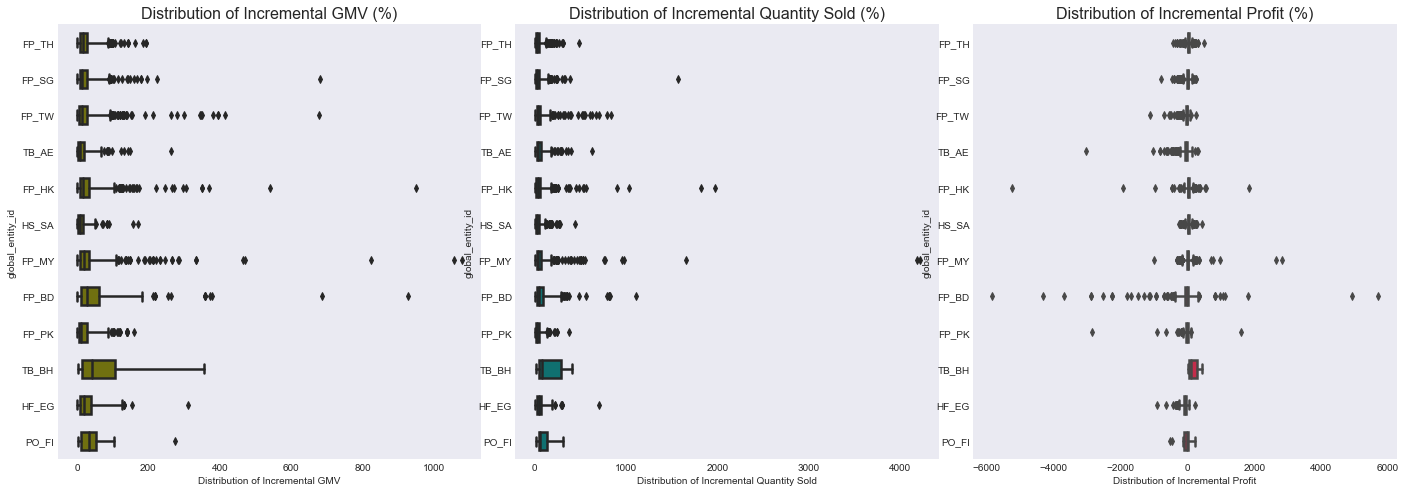

In [125]:
# Choose Columns
category_col = ['global_entity_id']
cols_of_interest = ['incremental_quantity_tab', 'incremental_gmv_tab','incremental_profit_ext_tab']
# Loop through Columns
for cols in cols_of_interest:
    display(df.groupby(category_col)[cols].describe(percentiles=[0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]).sort_values(by=['mean'], ascending = False).rename_axis(cols)\
                                                                                                                    .style.format({"count": "{0:.0f}", 
                                                                                                                          "mean": "{0:.2f}", 
                                                                                                                          "std": "{0:.2f}",
                                                                                                                          "min":"{0:.2f}",
                                                                                                                           "1%": "{0:.2f}",
                                                                                                                           "5%": "{0:.2f}",
                                                                                                                          "10%": "{0:.2f}",
                                                                                                                          "25%": "{0:.2f}",
                                                                                                                          "50%": "{0:.2f}",
                                                                                                                          "75%": "{0:.2f}",
                                                                                                                          "90%": "{0:.2f}",
                                                                                                                          "95%": "{0:.2f}",
                                                                                                                         "95%": "{0:.2f}",
                                                                                                                         "99%": "{0:.2f}",
                                                                                                                          "max": "{0:.2f}"})\
                                                                                                                       .background_gradient(cmap='BuPu'))

fig, ax = plt.subplots(1,3, figsize = (24,8), sharey=False)
plt.subplots_adjust(wspace = 0.08)

# GMV
sns.boxplot(x = 'incremental_gmv_tab', y= 'global_entity_id', data = df, ax = ax[0], color = 'olive', whis = 3, width = 0.5, linewidth = 2.5)
ax[0].set_title('Distribution of Incremental GMV (%)', fontsize = 16)
ax[0].set_xlabel('Distribution of Incremental GMV')

# Quantity Sold
sns.boxplot(x = 'incremental_quantity_tab', y= 'global_entity_id', data = df, ax = ax[1], color = 'teal', whis = 3, width = 0.5, linewidth = 2.5)
ax[1].set_title('Distribution of Incremental Quantity Sold (%)', fontsize = 16)
ax[1].set_xlabel('Distribution of Incremental Quantity Sold')

# Quantity Sold
sns.boxplot(x = 'incremental_profit_ext_tab',y= 'global_entity_id', data = df, ax = ax[2], color = 'crimson', whis = 3, width = 0.5, linewidth = 2.5)
ax[2].set_title('Distribution of Incremental Profit (%)', fontsize = 16)
ax[2].set_xlabel('Distribution of Incremental Profit')

,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
discount,,,,,,,,,,,,,,
TB_AE,548,22.72,11.10,1.00,4.47,8.00,10.00,15.00,20.00,30.00,34.00,44.00,60.42,67.00
TB_BH,13,21.31,14.68,2.00,2.72,5.60,8.40,10.00,20.00,31.00,44.60,47.00,47.00,47.00
PO_FI,12,21.17,13.23,8.00,8.11,8.55,9.10,10.75,14.00,34.75,40.00,40.00,40.00,40.00
HF_EG,274,18.30,8.36,1.00,3.73,7.00,9.00,12.00,18.00,23.75,28.70,32.00,43.16,51.00
HS_SA,639,17.85,10.70,1.00,2.00,5.00,7.00,10.00,15.00,23.00,32.00,40.00,50.00,60.00
FP_MY,1385,17.13,9.21,1.00,5.00,5.00,9.00,10.00,15.00,23.00,26.00,33.00,50.00,73.00
FP_TW,1310,15.91,11.07,1.00,2.00,4.00,6.00,8.00,12.00,20.00,32.10,40.00,50.00,64.00
FP_HK,1454,14.46,9.14,1.00,3.00,4.00,5.00,9.00,12.00,18.00,27.00,32.35,46.00,87.00
FP_SG,2243,13.42,7.63,1.00,3.00,4.00,5.00,8.00,12.00,18.00,22.00,26.00,41.16,50.00


,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
externally_funded_percentage,,,,,,,,,,,,,,
TB_BH,13,100.00,0.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00
FP_TH,1269,90.51,25.60,0.00,0.00,0.00,80.00,97.50,100.00,100.00,100.00,100.00,100.00,100.00
HS_SA,639,79.07,38.93,0.00,0.00,0.00,0.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00
FP_HK,1454,73.52,43.90,0.00,0.00,0.00,0.00,0.00,100.00,100.00,100.00,100.00,100.00,100.00
FP_SG,2243,62.98,41.44,0.00,0.00,0.00,0.00,5.50,80.00,100.00,100.00,100.00,100.00,100.00
FP_MY,1385,60.82,31.86,0.00,0.00,0.00,0.00,50.00,79.00,80.00,87.00,100.00,100.00,100.00
FP_BD,552,32.53,46.28,0.00,0.00,0.00,0.00,0.00,0.00,100.00,100.00,100.00,100.00,100.00
TB_AE,548,15.36,32.01,0.00,0.00,0.00,0.00,0.00,0.00,2.00,76.30,100.00,100.00,100.00
FP_PK,468,12.59,26.32,0.00,0.00,0.00,0.00,0.00,0.00,0.00,50.00,50.00,100.00,100.00


,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
number_of_campaign_days,,,,,,,,,,,,,,
FP_TW,1310,515.35,3615.24,0.00,0.00,0.00,1.00,3.00,11.50,102.00,239.00,247.00,28821.00,28821.00
TB_AE,548,36.57,66.83,0.00,0.00,1.00,2.00,5.00,10.00,26.00,211.00,216.85,220.00,274.00
FP_BD,552,22.80,14.77,0.00,0.00,2.00,5.00,11.00,26.00,30.00,31.00,45.35,68.80,151.00
FP_PK,468,18.70,19.50,0.00,0.00,1.00,2.00,6.00,13.00,25.00,38.00,61.00,89.82,126.00
FP_SG,2243,16.59,16.52,0.00,1.00,3.00,5.00,7.00,7.00,28.00,31.00,35.90,90.00,122.00
FP_HK,1454,16.34,11.20,0.00,0.00,1.00,5.00,7.00,15.00,25.75,31.00,31.00,59.00,74.00
FP_TH,1269,12.78,10.17,0.00,1.00,2.00,4.00,7.00,9.00,15.00,29.00,31.00,32.00,80.00
HF_EG,274,12.08,4.79,0.00,0.00,2.65,6.00,10.00,13.00,14.00,15.00,21.00,21.00,21.00
FP_MY,1385,9.66,6.70,0.00,0.00,1.00,2.00,6.00,7.00,14.00,17.00,20.80,31.00,50.00


Text(0.5, 0, 'Distribution of number of campaign days')

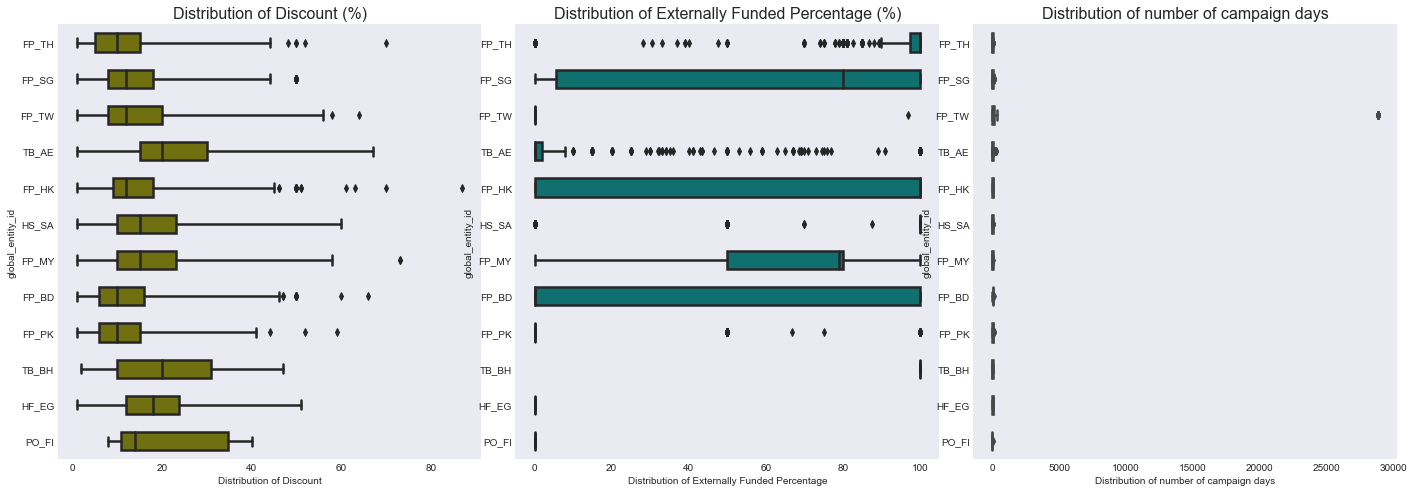

In [126]:
# Choose Columns

category_col = ['global_entity_id']
cols_of_interest = ['discount', 'externally_funded_percentage','number_of_campaign_days']
# Loop through Columns
for cols in cols_of_interest:
    display(df.groupby(category_col)[cols].describe(percentiles=[0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]).sort_values(by=['mean'], ascending = False).rename_axis(cols)\
                                                                                                                    .style.format({"count": "{0:.0f}", 
                                                                                                                          "mean": "{0:.2f}", 
                                                                                                                          "std": "{0:.2f}",
                                                                                                                          "min":"{0:.2f}",
                                                                                                                           "1%": "{0:.2f}",
                                                                                                                           "5%": "{0:.2f}",
                                                                                                                          "10%": "{0:.2f}",
                                                                                                                          "25%": "{0:.2f}",
                                                                                                                          "50%": "{0:.2f}",
                                                                                                                          "75%": "{0:.2f}",
                                                                                                                          "90%": "{0:.2f}",
                                                                                                                          "95%": "{0:.2f}",
                                                                                                                         "95%": "{0:.2f}",
                                                                                                                         "99%": "{0:.2f}",
                                                                                                                          "max": "{0:.2f}"})\
                                                                                                                       .background_gradient(cmap='Greens'))

fig, ax = plt.subplots(1,3, figsize = (24,8), sharey=False)
plt.subplots_adjust(wspace = 0.08)

# GMV
sns.boxplot(x = 'discount', y= 'global_entity_id', data = df, ax = ax[0], color = 'olive', whis = 3, width = 0.5, linewidth = 2.5)
ax[0].set_title('Distribution of Discount (%)', fontsize = 16)
ax[0].set_xlabel('Distribution of Discount')

# Quantity Sold
sns.boxplot(x = 'externally_funded_percentage', y= 'global_entity_id', data = df, ax = ax[1], color = 'teal', whis = 3, width = 0.5, linewidth = 2.5)
ax[1].set_title('Distribution of Externally Funded Percentage (%)', fontsize = 16)
ax[1].set_xlabel('Distribution of Externally Funded Percentage')

# Quantity Sold
sns.boxplot(x = 'number_of_campaign_days',y= 'global_entity_id', data = df, ax = ax[2], color = 'crimson', whis = 3, width = 0.5, linewidth = 2.5)
ax[2].set_title('Distribution of number of campaign days', fontsize = 16)
ax[2].set_xlabel('Distribution of number of campaign days')

#### Group Data by Country Level

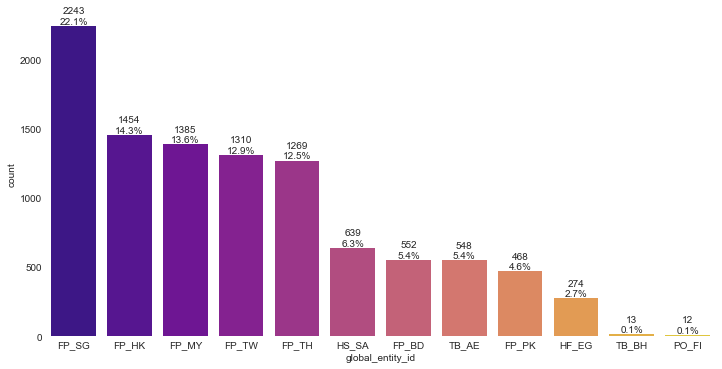

In [136]:
fig, ax = plt.subplots(figsize=(12, 6))
single_countplot(df, x='global_entity_id', ax=ax)
plt.show()

In [34]:
countries_agg = df.groupby(by='global_entity_id', as_index=False).agg({'incremental_gmv_tab': 'mean',
                                                                        'incremental_quantity_tab': 'mean',
                                                                        'incremental_profit_ext_tab': 'mean',
                                                                        'discount':'mean',
                                                                        'externally_funded_percentage': 'mean'})
countries_agg.columns = ['country', 'mean_incremental_gmv', 'mean_incremental_quantity', 'mean_incremental_profit_ext', 'mean_discount', 'mean_externally_funded_percentage']
countries_agg = countries_agg.sort_values(by='mean_incremental_profit_ext', ascending=False)
countries_agg = countries_agg.loc[:, ['country', 'mean_incremental_gmv', 'mean_incremental_quantity', 'mean_incremental_profit_ext', 'mean_discount', 'mean_externally_funded_percentage']]
countries_agg.sort_values(by='mean_incremental_profit_ext',ascending = False).reset_index(drop = True).style.set_properties(**{                                                  
                                    'color': 'white',                       
                                    'border-color': 'white'})\
                         .format({"BasePay": "${:20,.0f}", 
                          "mean_incremental_gmv": "{0:.2f}", 
                          "mean_incremental_quantity": "{0:.2f}",
                          "mean_incremental_profit_ext": "{0:.2f}",
                        "mean_discount": "{0:.2f}",                                                                                          
                          "mean_externally_funded_percentage":"{0:.2f}"})\
                 .hide_index()\
                .background_gradient(subset=['mean_incremental_gmv','mean_incremental_quantity','mean_incremental_profit_ext'], cmap='RdYlGn')\
                .background_gradient(subset=['mean_discount', 'mean_externally_funded_percentage'], cmap='Blues')

country,mean_incremental_gmv,mean_incremental_quantity,mean_incremental_profit_ext,mean_discount,mean_externally_funded_percentage
TB_BH,83.18,146.73,158.37,21.31,100.00
FP_TH,22.04,39.85,29.86,11.33,90.51
FP_HK,26.64,53.20,25.10,14.46,73.52
HS_SA,12.34,41.24,24.29,17.85,79.07
FP_SG,20.88,41.95,5.04,13.42,62.98
FP_MY,31.11,68.04,3.11,17.13,60.82
FP_PK,22.03,40.14,-24.23,11.75,12.59
FP_TW,25.55,53.57,-27.04,15.91,0.07
TB_AE,15.21,55.07,-67.72,22.72,15.36
FP_BD,49.28,79.61,-68.75,13.15,32.53


<AxesSubplot:xlabel='mean_incremental_gmv', ylabel='country'>

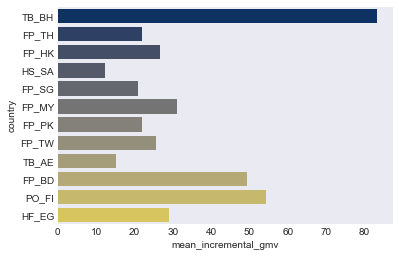

In [140]:
sns.barplot(y = 'country', x = 'mean_incremental_gmv', data = countries_agg, palette = 'cividis')

<AxesSubplot:xlabel='mean_incremental_profit_ext', ylabel='country'>

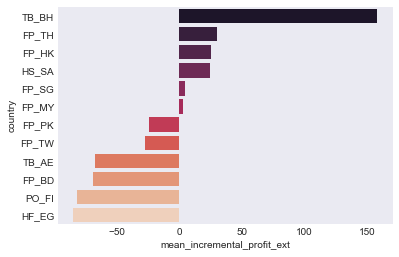

In [138]:
sns.barplot(y = 'country', x = 'mean_incremental_profit_ext', data = countries_agg, palette = 'rocket')

In [127]:
plt.figure(figsize=(12,6))
sns.barplot(x=countries, y=loss_over_gmv.index, palette='rocket')
plt.title("Restaurants Ranked by Biggest Loss over GMV", size=16)
plt.xlabel("Loss over GMV", size=14)
plt.ylabel('Restaurants', size=14);

,country,mean_incremental_gmv,mean_incremental_quantity,mean_incremental_profit_ext,mean_discount,mean_externally_funded_percentage
11,TB_BH,83.176165,146.728991,158.372686,21.307692,100.000000
5,FP_TH,22.037012,39.847197,29.862000,11.327817,90.509480
1,FP_HK,26.643311,53.201742,25.096279,14.456671,73.516052
8,HS_SA,12.339068,41.241756,24.286640,17.845070,79.072770
4,FP_SG,20.883615,41.949124,5.035423,13.420865,62.977637


#### Simple Correlation Checks

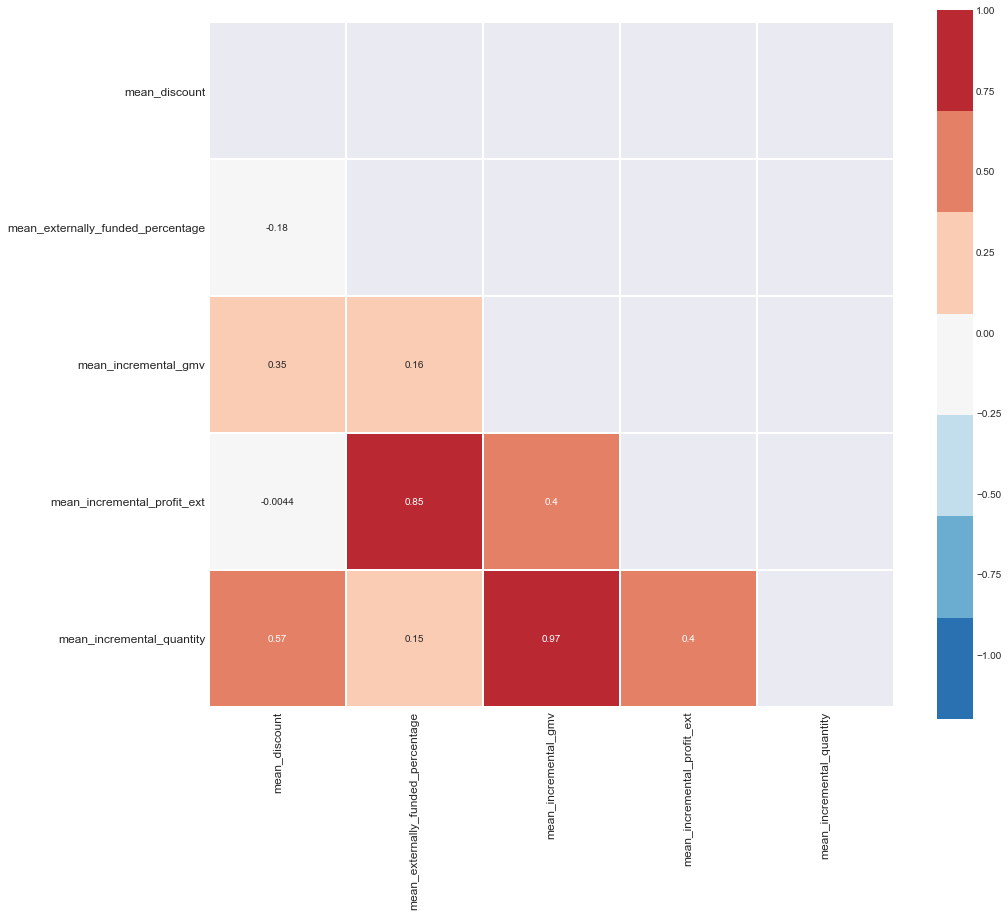

In [35]:
# order columns
rship = countries_agg[countries_agg.columns.sort_values()]

# plot heatmap
mask = np.zeros_like(rship.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)]= True

f, ax = plt.subplots(figsize=(15, 20))
sns.heatmap(rship.corr(),
            mask = mask,
            square=True,
            vmin = -1.2,
            vmax = 1,
            linewidth=0.1,
            cbar_kws = {'shrink':0.5},
            cmap=sns.color_palette("RdBu_r", 7), annot=True)
ax.tick_params(labelsize=12)
plt.tight_layout()

#### What correlates most with profitability?

                                   mean_incremental_profit_ext
mean_incremental_profit_ext                           1.000000
mean_externally_funded_percentage                     0.847827
mean_incremental_quantity                             0.401966
mean_incremental_gmv                                  0.398913
mean_discount                                         0.004417


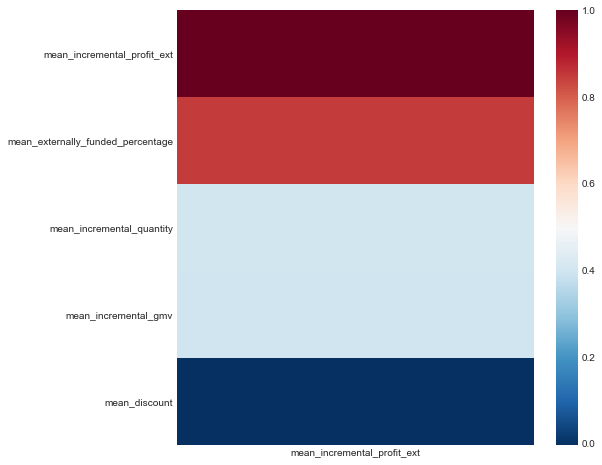

In [36]:
print(np.abs(countries_agg.corr())[['mean_incremental_profit_ext']].sort_values('mean_incremental_profit_ext', ascending=False).head(10))
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(countries_agg.corr()[['mean_incremental_profit_ext']].sort_values('mean_incremental_profit_ext'),
             cmap='RdBu_r', ax=ax);
ax.invert_yaxis()

In [37]:
# Create new columns
df['price_difference'] = df['price_base'] - df['price']
df['y_pred_uplift'] = df['y_pred'] - df['y_pred_base']
df['y_pred_uplift_perc'] = (df['y_pred'] - df['y_pred_base'])/df['y_pred_base'] * 100
df['qty_uplift'] = df['qty_sold'] - df['b_qty']
df['qty_uplift_perc'] = (df['qty_sold'] - df['b_qty'])/df['b_qty'] * 100
df['gmv_uplift'] =  df['gmv'] - df['b_gmv'] 
df['gmv_uplift_perc'] = ((df['gmv'] - df['b_gmv'])/df['b_gmv']) * 100
df['profit_ext_uplift'] = df['profit_ext'] - df['b_profit']
df['profit_ext_uplift_perc'] = ((df['profit_ext'] - df['b_profit'])/df['b_profit']) * 100

#### Rows where the predicted quantity sold baseline (without discount) is higher than what is predicted qty sold (after discount)

In [38]:
print(f'Percentage rows where y_pred_base > y_pred: {np.round(df.query("y_pred_base > y_pred").shape[0]/df.shape[0] * 100,2)}%')
df.query('y_pred_base > y_pred')[['order_date','global_entity_id','campaign_name','product','sku','y_pred_base','y_pred','y_pred_uplift','y_pred_uplift_perc']].sort_values(by=['y_pred_uplift_perc']).head()

Percentage rows where y_pred_base > y_pred: 0.0%


,order_date,global_entity_id,campaign_name,product,sku,y_pred_base,y_pred,y_pred_uplift,y_pred_uplift_perc


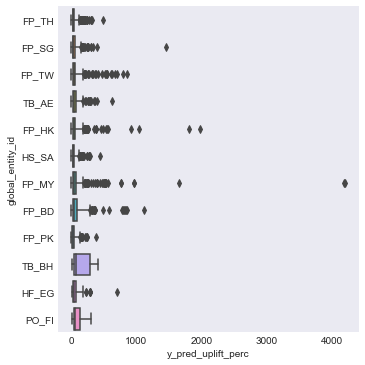

In [39]:
sns.catplot(x='y_pred_uplift_perc', 
            y = 'global_entity_id',
            data=df, 
            kind ='box',
            whis = 3)

In [40]:
df.query('y_pred_uplift_perc > 12000')[['order_date','global_entity_id','campaign_name','product','sku','y_pred_base','y_pred','y_pred_uplift','y_pred_uplift_perc']].sort_values(by=['y_pred_uplift_perc']).head()

,order_date,global_entity_id,campaign_name,product,sku,y_pred_base,y_pred,y_pred_uplift,y_pred_uplift_perc


#### Rows where Price after discount is higher than Price before discount

In [41]:
print(f'Percentage rows where Price > Price_Base: {np.round(df.query("price > price_base").shape[0]/df.shape[0] * 100,2)}%')
df.query("price > price_base")[['order_date','global_entity_id','campaign_name','product','sku','price','price_base','price_difference']].sort_values(by=['price_difference']).head()

Percentage rows where Price > Price_Base: 0.0%


,order_date,global_entity_id,campaign_name,product,sku,price,price_base,price_difference


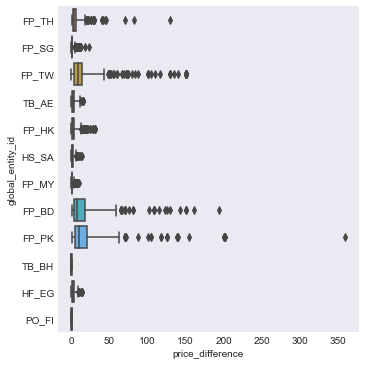

In [42]:
sns.catplot(x='price_difference', 
            y = 'global_entity_id',
            data=df, 
            kind ='box',
            whis = 3)

In [43]:
df.query("price_difference > 400")[['order_date','global_entity_id','campaign_name','product','sku','price','price_base','price_difference']].sort_values(by=['price_difference']).head()

,order_date,global_entity_id,campaign_name,product,sku,price,price_base,price_difference


#### Rows where Baseline Quantity > Quantity Sold

In [44]:
print(f'Percentage rows where Baseline Quantity > Quantity: {np.round(df.query("b_qty > qty_sold").shape[0]/df.shape[0] * 100,2)}%')
df.query("b_qty > qty_sold")[['order_date','global_entity_id','campaign_name','product','sku','qty_sold','b_qty','qty_uplift','qty_uplift_perc']].sort_values(by=['qty_uplift_perc']).head()

Percentage rows where Baseline Quantity > Quantity: 0.0%


,order_date,global_entity_id,campaign_name,product,sku,qty_sold,b_qty,qty_uplift,qty_uplift_perc


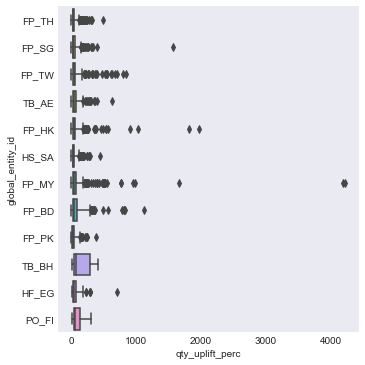

In [45]:
sns.catplot(x='qty_uplift_perc', 
            y = 'global_entity_id',
            data=df, 
            kind ='box',
            whis = 3)

In [46]:
df.query("qty_uplift_perc > 8000")[['order_date','global_entity_id','campaign_name','product','sku','qty_sold','b_qty','qty_uplift','qty_uplift_perc']].sort_values(by=['qty_uplift_perc'], ascending = False).head()

,order_date,global_entity_id,campaign_name,product,sku,qty_sold,b_qty,qty_uplift,qty_uplift_perc


#### Rows where Baseline GMV > GMV

In [47]:
print(f'Percentage rows where Baseline GMV > GMV: {np.round(df.query("b_gmv > gmv").shape[0]/df.shape[0] * 100,2)}%')
df.query("b_gmv > gmv")[['order_date','global_entity_id','campaign_name','product','sku','gmv','b_gmv','gmv_uplift','gmv_uplift_perc']].sort_values(by=['gmv_uplift_perc']).head()

Percentage rows where Baseline GMV > GMV: 0.0%


,order_date,global_entity_id,campaign_name,product,sku,gmv,b_gmv,gmv_uplift,gmv_uplift_perc


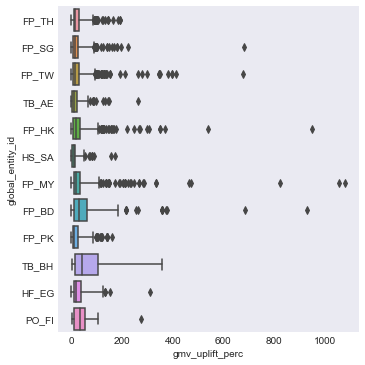

In [48]:
sns.catplot(x='gmv_uplift_perc', 
            y = 'global_entity_id',
            data=df, 
            kind ='box',
            whis = 3)

In [49]:
df.query('gmv_uplift_perc > 3000')[['global_entity_id','product','sku','campaign_name','b_gmv','gmv','gmv_uplift','gmv_uplift_perc']].sort_values(by=['gmv_uplift_perc'], ascending = False).head()

,global_entity_id,product,sku,campaign_name,b_gmv,gmv,gmv_uplift,gmv_uplift_perc


#### Rows where b_profit > profit_ext

In [50]:
print(f'Percentage rows where Baseline Profit > Profit External: {np.round(df.query("b_profit > profit_ext").shape[0]/df.shape[0] * 100,2)}%')
df.query("b_profit > profit_ext")[['order_date','global_entity_id','campaign_name','product','sku','profit','profit_ext','b_profit','profit_ext_uplift','profit_ext_uplift_perc','incremental_profit_ext_tab']].sort_values(by=['profit_ext_uplift_perc']).tail()

Percentage rows where Baseline Profit > Profit External: 41.24%


,order_date,global_entity_id,campaign_name,product,sku,profit,profit_ext,b_profit,profit_ext_uplift,profit_ext_uplift_perc,incremental_profit_ext_tab
5461,2021-09-28,FP_BD,Zero_Banner_EMF____OSD__W4_Sep'21_v1,Egg Broiler 12 Pcs (45 gm+ Per Pc),P421S6,-2506.25,-2506.25,-215.45,-2290.80,1063.262938,1063.262938
9297,2021-10-20,FP_PK,Dawn + Bread & Beyond - With banner - Lahore EC[CLONE],Dawn White Bread Vitamin Enriched Medium,736YZR,-13.00,-13.00,-0.77,-12.23,1588.311688,1588.311688
4145,2021-06-20,FP_BD,Monthly_Edible Oil_Soyabean Oil__flat__All_WK1_May21_V1[CLONE][CLONE],Pusti Fortified Soybean Oil 5 L,3150I7,-585.60,-585.60,-30.70,-554.90,1807.491857,1807.491857
4395,2021-08-23,FP_BD,perishable_weekend_campaign_ISD_22ndAug21_V3,Egg Broiler 12 Pcs (45 gm+ Per Pc),P421S6,-7780.92,-7780.92,-155.06,-7625.86,4918.005933,4918.005933
7854,2021-07-05,FP_BD,Masher Bazar_Perishable___flat__All__W1_July21_v1,Imported Onion 1 kg,1UU2EQ,-110.00,-110.00,-1.90,-108.10,5689.473684,5689.473684


#### Rows where Profit > Profit with External Funding

In [51]:
df['external_funding_calc_from_profit'] = df['profit_ext'] - df['profit']
print(f'Percentage rows where Profit > Profit with External Funding: {np.round(df.query("profit > profit_ext").shape[0]/df.shape[0] * 100,2)}%')
df.query("profit > profit_ext")[['order_date','global_entity_id','campaign_name','product','sku','profit','profit_ext','external_funding_calc_from_profit', 'externally_funded_percentage']].sort_values(by=['external_funding_calc_from_profit']).head()

Percentage rows where Profit > Profit with External Funding: 0.0%


,order_date,global_entity_id,campaign_name,product,sku,profit,profit_ext,external_funding_calc_from_profit,externally_funded_percentage


#### Rows where Discounts > 100

In [52]:
print(f'Percentage rows where Discount > 100: {np.round(df.query("discount > 100").shape[0]/df.shape[0] * 100,4)}%')
df.query("discount > 100")[['order_date','global_entity_id','campaign_name','product','sku','discount']].sort_values(by=['discount'],ascending = False).head()

Percentage rows where Discount > 100: 0.0%


,order_date,global_entity_id,campaign_name,product,sku,discount


#### Rows where Externally Funded Percentage > 100

In [53]:
print(f'Percentage rows where Externally Funded Percentage > 100: {np.round(df.query("externally_funded_percentage > 100").shape[0]/df.shape[0] * 100,2)}%')
df.query("externally_funded_percentage > 100")[['order_date','global_entity_id','campaign_name','product','sku','externally_funded_percentage']].sort_values(by=['externally_funded_percentage'],ascending = False).head()

Percentage rows where Externally Funded Percentage > 100: 0.0%


,order_date,global_entity_id,campaign_name,product,sku,externally_funded_percentage


#### Rows where Creation of campaign is after is start date

In [54]:
df['no_of_days_created_after_start'] = (df['campaign_created_time_utc'] - df['campaign_start_time_utc']).dt.days

In [55]:
df.query("no_of_days_created_after_start > 3")[['order_date','global_entity_id','campaign_name','product','sku','campaign_created_time_utc','campaign_start_time_utc','no_of_days_created_after_start']].sort_values(by=['campaign_created_time_utc'], 
ascending = False).head()

,order_date,global_entity_id,campaign_name,product,sku,campaign_created_time_utc,campaign_start_time_utc,no_of_days_created_after_start


#### Great Expectations

In [56]:
import great_expectations as ge

In [57]:
my_df = ge.from_pandas(df)

In [58]:
my_df.expect_column_values_to_be_between(['discount'],0,100)

{
  "meta": {},
  "success": true,
  "result": {
    "element_count": 10167,
    "missing_count": 0,
    "missing_percent": 0.0,
    "unexpected_count": 1,
    "unexpected_percent": 0.009835743090390479,
    "unexpected_percent_total": 0.009835743090390479,
    "unexpected_percent_nonmissing": 0.009835743090390479,
    "partial_unexpected_list": [
      "discount"
    ]
  },
  "exception_info": {
    "raised_exception": false,
    "exception_traceback": null,
    "exception_message": null
  }
}

In [59]:
df.query("discount > 100")[['order_date','global_entity_id','campaign_name','product','sku','discount']].sort_values(by=['discount'],ascending = False).head()

,order_date,global_entity_id,campaign_name,product,sku,discount


In [60]:
# Qty_sold should be greater than Baseline Quantity
my_df.expect_column_pair_values_A_to_be_greater_than_B("qty_sold", "b_qty",or_equal = True)

{
  "meta": {},
  "success": true,
  "result": {
    "element_count": 10167,
    "missing_count": 0,
    "missing_percent": 0.0,
    "unexpected_count": 0,
    "unexpected_percent": 0.0,
    "unexpected_percent_total": 0.0,
    "unexpected_percent_nonmissing": 0.0,
    "partial_unexpected_list": []
  },
  "exception_info": {
    "raised_exception": false,
    "exception_traceback": null,
    "exception_message": null
  }
}

In [61]:
my_df.get_expectation_suite(discard_failed_expectations=False)

{
  "meta": {
    "great_expectations_version": "0.13.41"
  },
  "data_asset_type": "Dataset",
  "expectations": [
    {
      "expectation_type": "expect_column_values_to_be_between",
      "meta": {},
      "kwargs": {
        "column": [
          "discount"
        ],
        "min_value": 0,
        "max_value": 100
      },
      "ge_cloud_id": null
    },
    {
      "expectation_type": "expect_column_pair_values_A_to_be_greater_than_B",
      "meta": {},
      "kwargs": {
        "column_A": "qty_sold",
        "column_B": "b_qty",
        "or_equal": true
      },
      "ge_cloud_id": null
    }
  ],
  "ge_cloud_id": null,
  "expectation_suite_name": "default"
}